## Setup

In [1]:
import sys
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import scipy as sp
import isuelogit as isl
import seaborn as sns
from datetime import datetime

from pesuelogit.visualizations import plot_heatmap_demands
from pesuelogit.models import compute_rr
from pesuelogit.networks import build_tntp_network
from pesuelogit.etl import get_design_tensor, add_period_id

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

main dir: /Users/pablo/github/nesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

# Internal modules
from nesuelogit.models import ODParameters, UtilityParameters, create_model_tntp, create_bpr, create_mlp_tntp, \
    create_tvodlulpe_model_tntp, create_tvgodlulpe_model_tntp, train_val_split_by_links, train_kfold, compute_generated_trips, \
    compute_generation_factors, compute_benchmark_metrics, create_suelogit
from nesuelogit.visualizations import plot_predictive_performance, plot_metrics_kfold, \
    plot_top_od_flows_periods, plot_utility_parameters_periods, plot_flow_vs_traveltime, plot_performance_functions, \
    plot_annotate_r2, plot_flow_interaction_matrix, plot_parameters_kfold, plot_parameters, plot_convergence_estimates, \
    compute_total_trips_models
from nesuelogit.metrics import mse, mape, r2_score, z2score
from nesuelogit.utils import load_k_shortest_paths

### Hyperparameters and configurations

In [4]:
#Loss function
_LOSS_WEIGHTS = {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}
_LOSS_METRIC = z2score

#Optimization
_BATCH_SIZE = 1
_EPOCHS = {'learning': 60, 'equilibrium': 0}
_LR = {'learning': 5e-2, 'equilibrium': 5e-3}
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
               'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
               }
# Equilibrium condition (if different than 'inf', equilibrium 'epochs' must be greater than 0)
_RELATIVE_GAP = float('inf')

## Exogenous features in utility function
_FEATURES_Z = ['tt_sd', 's']

# K-Fold
_N_SPLITS = 5
_POLY_ORDER = 3
_LOSS_WEIGHTS_KFOLD = _LOSS_WEIGHTS.copy()
_EPOCHS_KFOLD = _EPOCHS.copy()

_DTYPE = tf.float32

In [5]:
# Seed for reproducibility
_SEED = 2024
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

# For report global runtime
t0_global = time.time()

## Build network

In [6]:
network_name = 'SiouxFalls'
network = build_tntp_network(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")

## Read and load OD matrix

In [7]:
# Load true demand matrix
Q = isl.reader.read_tntp_od(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")
network.load_OD(Q=Q)

Q_true = [network.OD.Q_true, 0.8*network.OD.Q_true]

# Dense representation of O-D matrix by period
q_true = tf.stack([network.OD.q_true.flatten(), 0.8*network.OD.q_true.flatten()], axis = 0)

Reading Q from external file
Matrix Q (24, 24) read in 0.1[s]                        

360600.0 trips were loaded among 528 o-d pairs


In [8]:
# Add some noise in the the true O-D matrix
Q_historic = [isl.factory.random_disturbance_Q(i.copy(), sd=np.mean(i) * 0.1) for i in Q_true]
q_historic = [isl.networks.denseQ(i.copy()).flatten() for i in Q_historic]

Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 52.0
Approximated proportion change: 7.6%
Mean of nonzero entries in the original demand matrix:  546.4
Mean absolute difference between the nonzero entries of the noisy and original: 38.6
Approximated proportion change: 7.1%


In [9]:
# Vectors of generated trips by period
generated_trips = compute_generated_trips(q=tf.stack(q_historic), ods=network.ods, n_nodes = len(network.nodes))

generated_trips

<tf.Tensor: shape=(2, 24), dtype=float64, numpy=
array([[ 9009.078 ,  3892.6202,  2921.6413, 11548.0757,  6200.4745,
         7392.1161, 12404.233 , 17029.7714, 16351.1746, 44846.4172,
        21969.2989, 13853.8144, 14276.9753, 13399.2092, 21350.6263,
        26085.6003, 23744.952 ,  4602.0228, 12971.3035, 18735.8556,
        10675.8056, 24328.8651, 14688.4072,  7720.2589],
       [ 7334.2814,  3510.9206,  2046.9991,  9432.0225,  4860.2445,
         6180.1929,  9588.6089, 12953.6178, 13000.4854, 36038.9385,
        18337.1259, 11060.3597, 11704.2975, 11386.6545, 17520.2877,
        20708.6772, 19127.3158,  3867.4954, 10461.9753, 15008.3759,
         8854.5891, 19719.4375, 11353.3008,  6143.9414]])>

## Generate paths

In [10]:
load_k_shortest_paths(network=network, k=3, update_incidence_matrices=True)

1584 paths were loaded and incidence matrices were built


## Read data

In [11]:
# Synthethic data which was generated with simulate-nesuelogit-data.ipynb notebook
df = pd.read_csv(
    main_dir + '/input/network-data/' + network.key + '/links/' + network.key + '-link-data.csv')
df

,timepoint,link_key,tt_sd,s,period,traveltime,counts
0,1,"(0, 1, '0')",0.255921,0.609116,1,5.399077,6382.163332
1,1,"(0, 2, '0')",0.867232,0.344233,1,3.401084,7443.341555
2,1,"(1, 0, '0')",0.016488,0.229669,1,5.399438,6618.745852
3,1,"(1, 5, '0')",0.552497,0.944626,1,7.807893,7985.756594
4,1,"(2, 0, '0')",0.527905,0.291726,1,3.400545,7206.760012
...,...,...,...,...,...,...,...
22795,300,"(22, 21, '0')",0.173890,0.739667,2,8.139833,8015.247081
22796,300,"(22, 23, '0')",0.881150,0.364632,2,2.418279,4894.220714
22797,300,"(23, 12, '0')",0.820056,0.348717,2,9.095124,8613.002941
22798,300,"(23, 20, '0')",0.736659,0.133531,2,8.627387,9111.788097


In [12]:
# Generate synthetic node data
node_data = pd.DataFrame({'key': [node.key for node in network.nodes],
                          'income': np.random.rand(len(network.nodes)),
                          'population': np.random.rand(len(network.nodes))
                          })

## Training and validation sets

In [13]:
n_timepoints = len(df.timepoint.unique())
n_links = len(network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in network.links], n_timepoints)

In [14]:
period_feature = 'hour'
df = df.rename(columns = {'period': 'hour'})
df = add_period_id(df, period_feature=period_feature)

period_keys = df[[period_feature, 'period_id']].drop_duplicates().reset_index().drop('index', axis=1).sort_values(period_feature)
print(period_keys)

   hour  period_id
0     1          0
1     2          1


In [15]:
X = get_design_tensor(Z=df[_FEATURES_Z + ['period_id']], n_links=n_links, n_timepoints=n_timepoints )
Y = get_design_tensor(y=df[['traveltime', 'counts']], n_links=n_links, n_timepoints=n_timepoints)

In [16]:
X, Y = [tf.cast(i, _DTYPE) for i in [X, Y]]

Y_train, Y_val = train_val_split_by_links(Y.numpy(), val_size=0)

In [17]:
n_periods = len(np.unique(X[:, :, -1].numpy().flatten()))

generation_factors = compute_generation_factors(period_column=X[:, :, -1, None].numpy(),
                                                flow_column=Y[:, :, 1, None].numpy(), reference_period=0)

## Models

In [18]:
models = {}
train_results_dfs = {}
val_results_dfs = {}

In [19]:
print(df)

       timepoint       link_key     tt_sd         s  hour  traveltime  \
0              1    (0, 1, '0')  0.255921  0.609116     1    5.399077   
1              1    (0, 2, '0')  0.867232  0.344233     1    3.401084   
2              1    (1, 0, '0')  0.016488  0.229669     1    5.399438   
3              1    (1, 5, '0')  0.552497  0.944626     1    7.807893   
4              1    (2, 0, '0')  0.527905  0.291726     1    3.400545   
...          ...            ...       ...       ...   ...         ...   
22795        300  (22, 21, '0')  0.173890  0.739667     2    8.139833   
22796        300  (22, 23, '0')  0.881150  0.364632     2    2.418279   
22797        300  (23, 12, '0')  0.820056  0.348717     2    9.095124   
22798        300  (23, 20, '0')  0.736659  0.133531     2    8.627387   
22799        300  (23, 22, '0')  0.846968  0.843456     2    2.371133   

            counts  tt_ff  period_id  
0      6382.163332    6.0          0  
1      7443.341555    4.0          0  
2     

## a) Equilibrium (SUELOGIT)

In [20]:
print('Gradient based SUELOGIT')

# Note: Here we assume we know the True OD matrix and the scale of the second period is obtained from the link flow data. Otherwise,
# the link flows and travel times obtained at equilibrium will not necessarily match the observed data.

t0 = time.time()

suelogit = create_suelogit(network = network, n_periods = n_periods, features_Z = _FEATURES_Z,
                           reference_q = generation_factors.values[:, np.newaxis] * network.q.flatten(),
                           dtype = _DTYPE)

train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.compute_equilibrium(
    X,
    node_data=node_data,
    optimizer=_OPTIMIZERS['equilibrium'],
    batch_size=_BATCH_SIZE,
    loss_weights={'equilibrium': 1},
    threshold_relative_gap=1e-4,
    epochs=200)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

Gradient based SUELOGIT

Computing gradient based equilibrium

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: 0.0001
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/200: train mse=9.8e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.89e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.71, train equilibrium loss=9.8e+07, time: 0.1

1/200: train mse=9.1e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.89e+05], avg alpha=0.15, avg beta=4, lambda eq=1, relative gap=0.68, train equilibrium loss=9.1e+07, time: 3.8

2/200: train mse=8.5e+07, avg theta = [-1.  -1.3 -3. ], avg rr = 1.30, avg theta fixed effect = 0, loss prop od=0, total trips=[3.61e+05 2.89e+05]

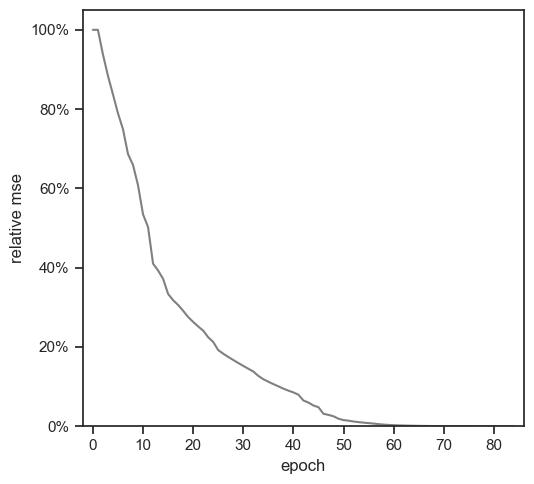

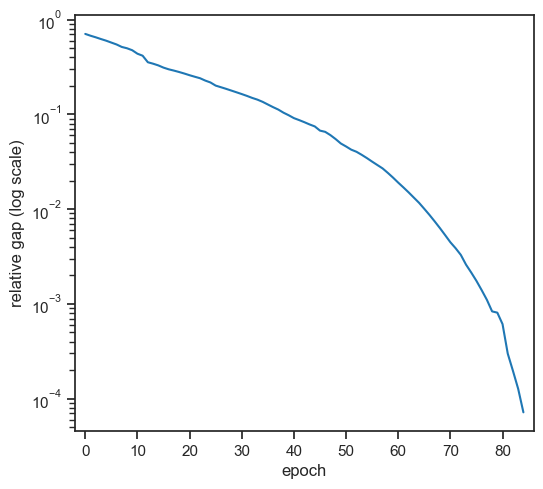

In [21]:
fig, ax = plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],
                            xticks_spacing=10, curves=['equilibrium'])

ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-suelogit.png', dpi=300)

plt.show()

train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

fig, ax = plot_convergence_estimates(
    estimates=train_results_losses.assign(
        relative_gap=np.abs(train_results_losses['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=10)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-suelogit.png', dpi=300)

plt.show()

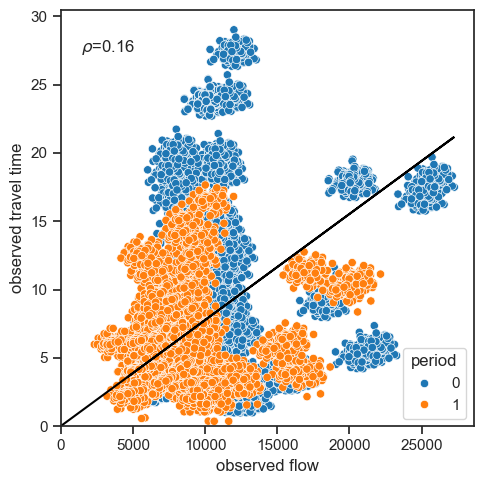

In [22]:
fig, ax = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        all_metrics = False,
                        only_observed = True,
                        ampm_format = False
                        )

ax.legend(loc='lower right', title = 'period')

ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime.png', dpi=300)

plt.show()

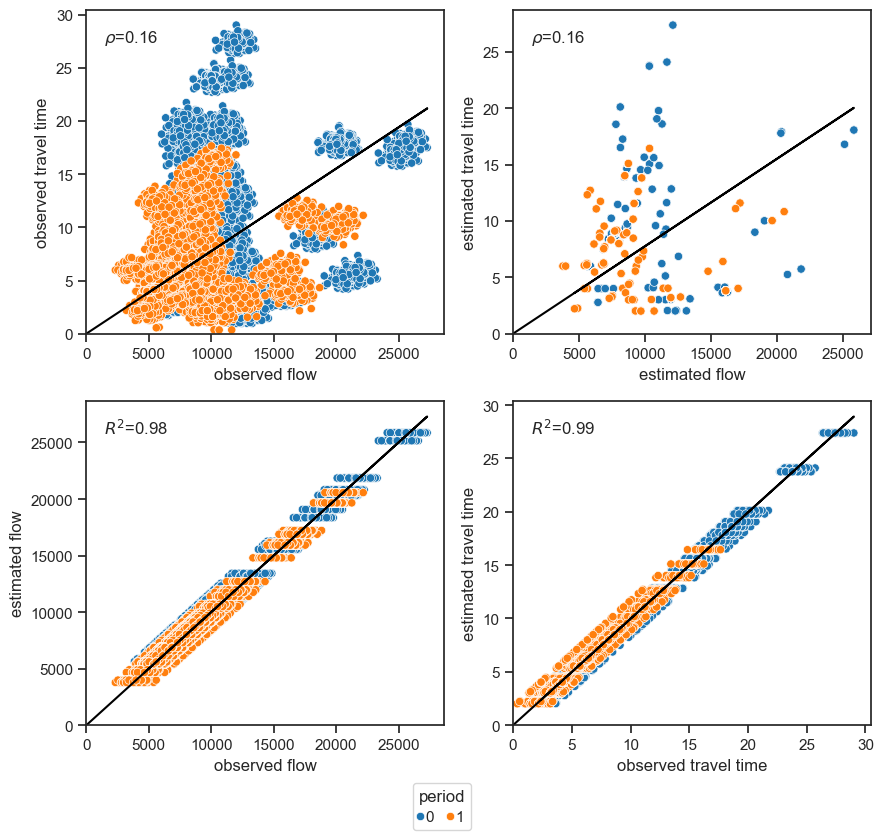

In [23]:
fig, axs = plot_flow_vs_traveltime(model = suelogit,
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        all_metrics = False,
                        ampm_format = False
                        )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-suelogit.png', dpi=300)

plt.show()

## b) Benchmark (TVODLULPE)

In [24]:

print('\ntvodlulpe: Time specific utility and OD, link performance parameters')

t0 = time.time()

models['tvodlulpe'] = create_tvodlulpe_model_tntp(network = network, n_periods = n_periods,
                                                  reference_q = q_historic, features_Z=_FEATURES_Z)

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    X, Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)


tvodlulpe: Time specific utility and OD, link performance parameters

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
Learning stage: 60 epochs

0/60: train mse=1.8e+07, train mse traveltime=30, train mape traveltime=44.5 train mse flow=8.7e+06, train mape flow=19.2, avg theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=2.9e-09, total trips=[3.60e+05 2.90e+05], avg alpha=1, avg beta=1, lambda eq=1, relative gap=0.41, train equilibrium loss=4.5e+07, time: 0.1

1/60: train mse=2.4e+06, train mse traveltime=1.7, train mape traveltime=11.7 train mse flow=3.5e+06, train mape flow=12.1, avg theta = [-0.237 -1.522 -1.312], avg rr = 6.42, avg theta fixed effect = -0.13, loss prop od=5.

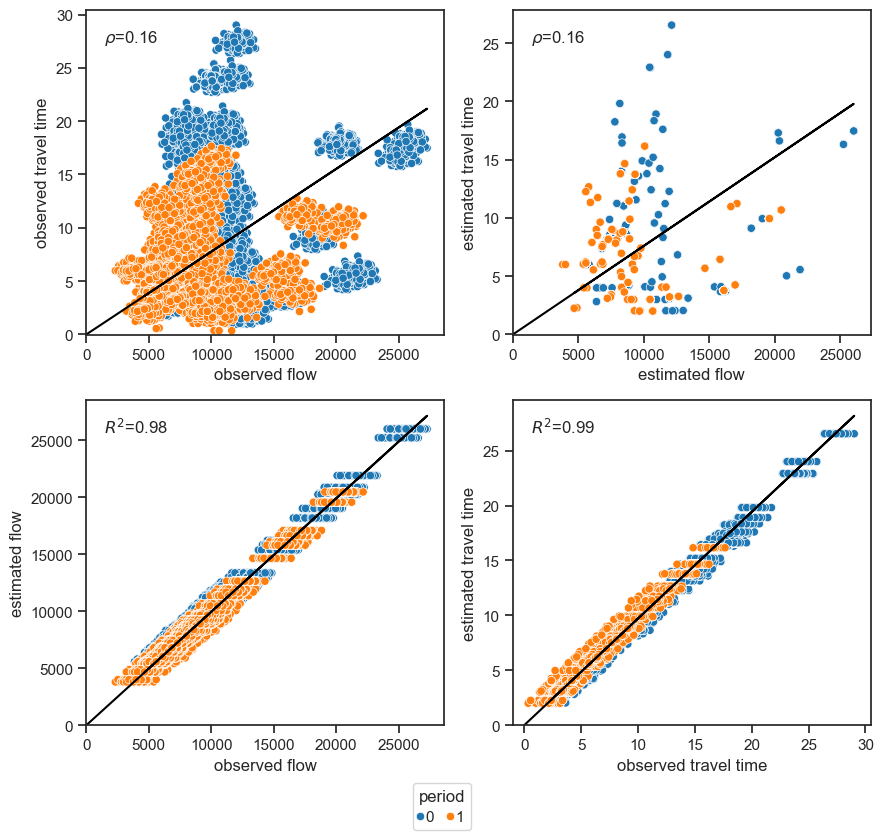

In [25]:
fig, axs = plot_flow_vs_traveltime(model = models['tvodlulpe'],
                                   observed_traveltime=Y[:, :, 0],
                                   observed_flow= Y[:,:,1],
                                   period_col = X[:,:,-1].numpy().astype(int).flatten(),
                                   all_metrics = False,
                                   ampm_format = False
                                   )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvodlulpe.png', dpi=300)

plt.show()

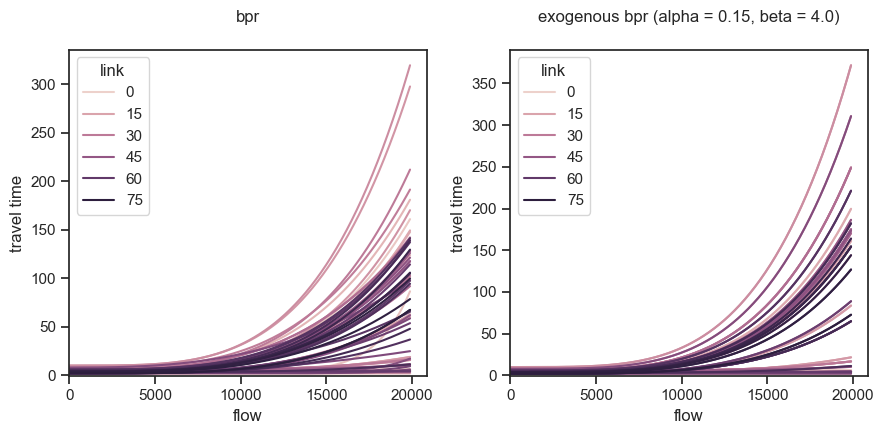

In [26]:
flow_range = range(0, 20000, 100)
sharey = False

fig, axs = plot_performance_functions(model = models['tvodlulpe'],
                                      network = network,
                                      marginal = False,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvodlulpe.png', dpi=300)

plt.show()

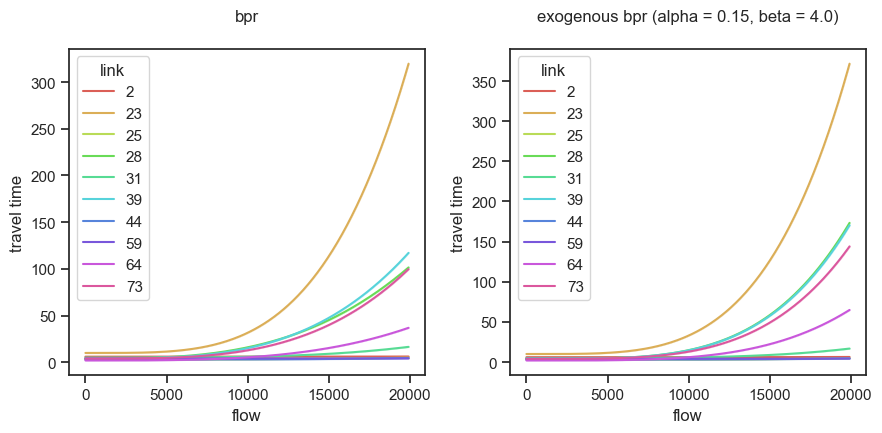

In [27]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

plot_performance_functions(model=models['tvodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

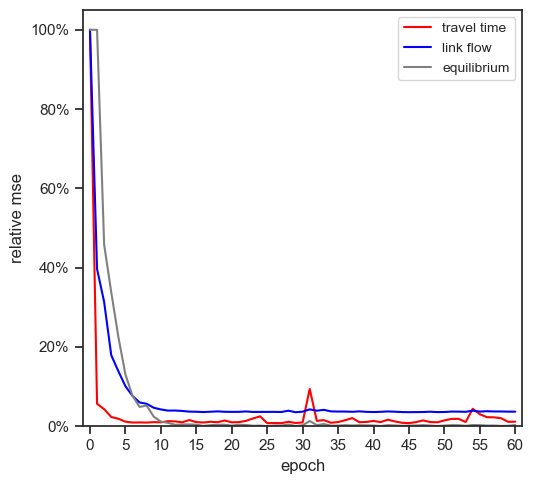

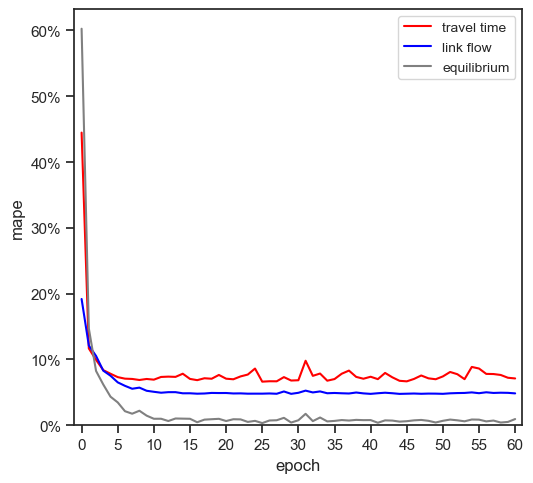

In [28]:
plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            # curves = ['link flow', 'travel time'],
                            xticks_spacing=5, show_validation=False,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvodlulpe.png', dpi = 300)

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'],
                            val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=5, show_validation=False, show_percentage_units = True,
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvodlulpe.png', dpi = 300)

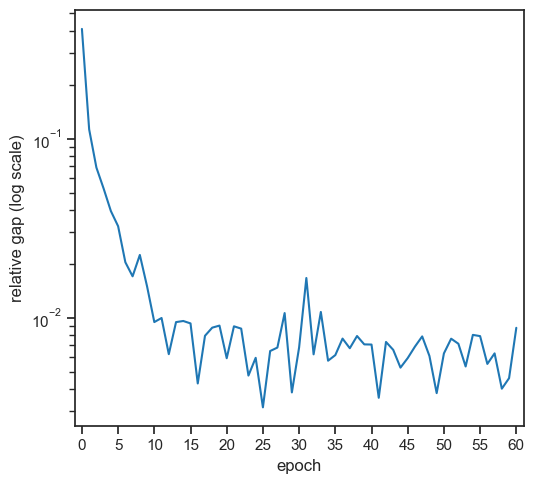

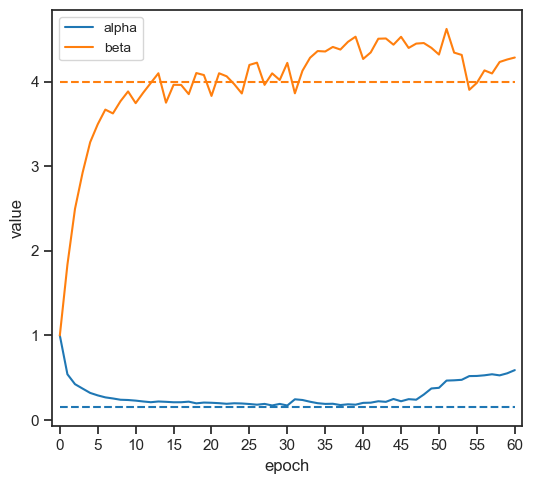

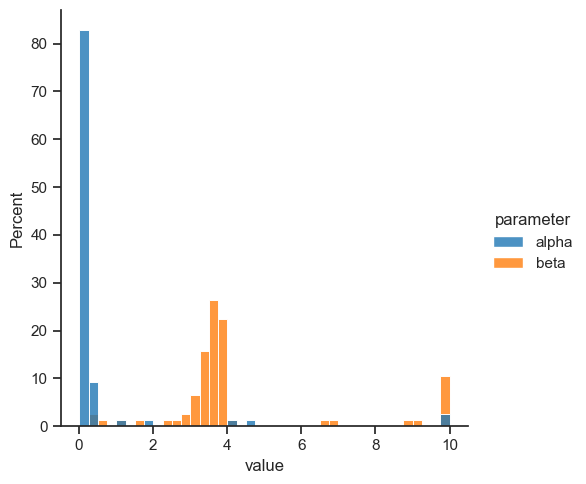

parameter
alpha    0.589945
beta     4.285080
Name: value, dtype: float32


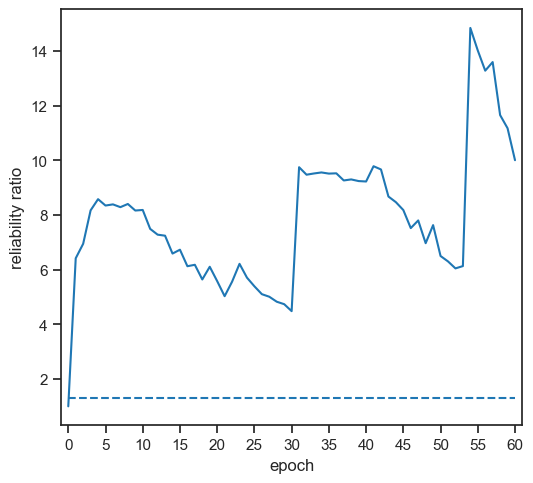

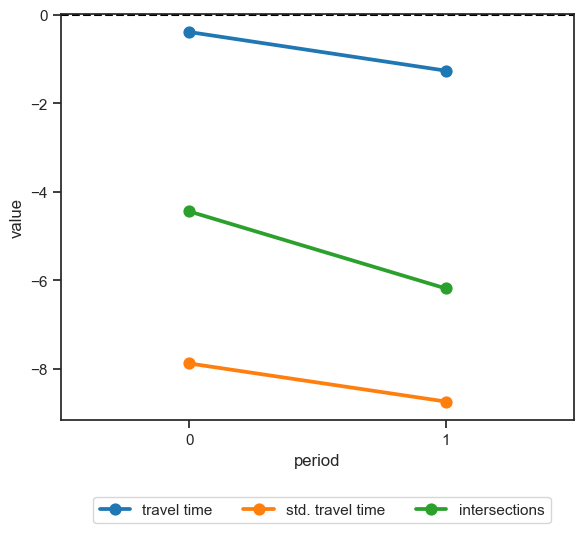

   period         parameter     value    group
0       0       travel time -0.394790  utility
1       1       travel time -1.267128  utility
2       0  std. travel time -7.881076  utility
3       1  std. travel time -8.741997  utility
4       0     intersections -4.447045  utility
5       1     intersections -6.186629  utility


In [29]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=5)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvodlulpe.png', dpi = 300)

plt.show()


plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                           xticks_spacing=5,
                           true_values=models['tvodlulpe'].performance_function.parameters.true_values,
                           )

plt.show()

plot_data = pd.melt(pd.DataFrame({'alpha': models['tvodlulpe'].performance_function.alpha,
                                  'beta': models['tvodlulpe'].performance_function.beta}), var_name='parameter')

try:
    sns.displot(plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8, facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
    plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvodlulpe.png', dpi=300)
    plt.show()
except:
    print('Distribution plot could not be shown')

print(plot_data.groupby('parameter')['value'].mean())

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe']. \
                           assign(rr=train_results_dfs['tvodlulpe']['tt_sd'] / train_results_dfs['tvodlulpe']['tt'])[['epoch', 'rr']],
                           true_values={'rr': models['tvodlulpe'].utility.true_values['tt_sd']/models['tvodlulpe'].utility.true_values['tt']},
                           xticks_spacing=5)
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, ax = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvodlulpe.png', dpi=300)

plt.show()

print(theta_df)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:935: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


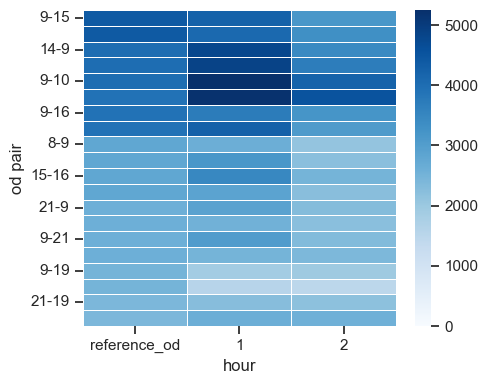

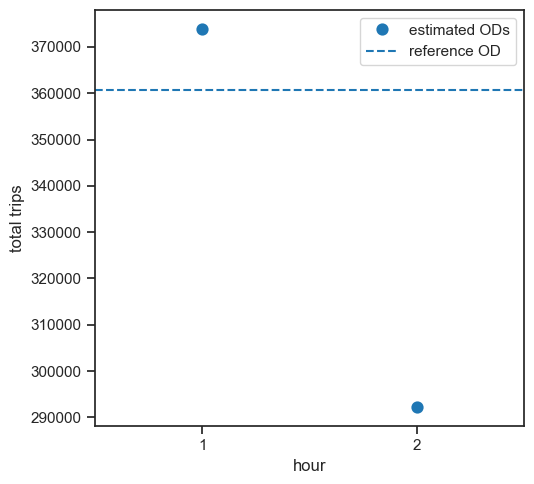

period 0

correlation: 0.9587246168340079


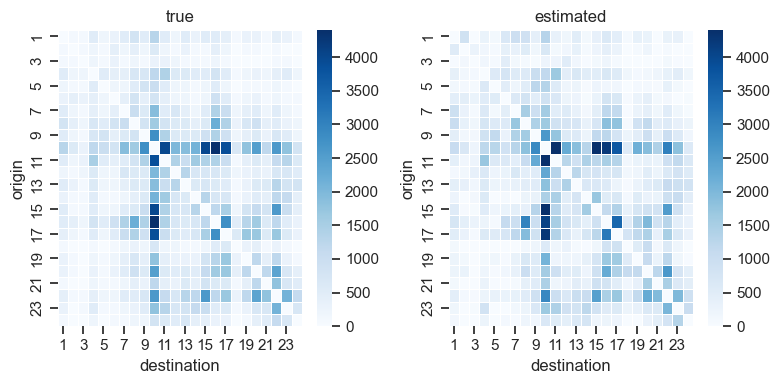

period 1

correlation: 0.9728346059932251


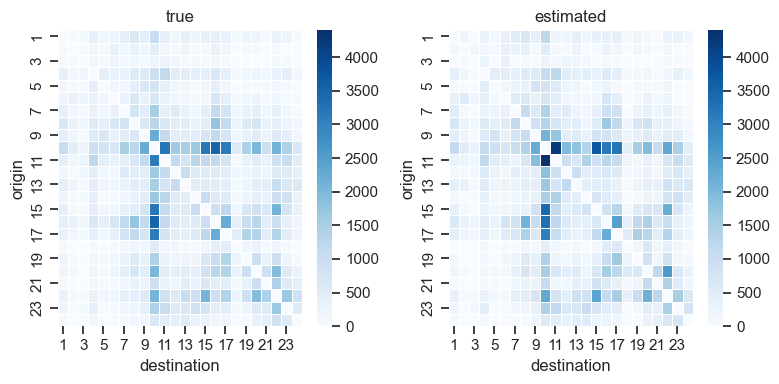

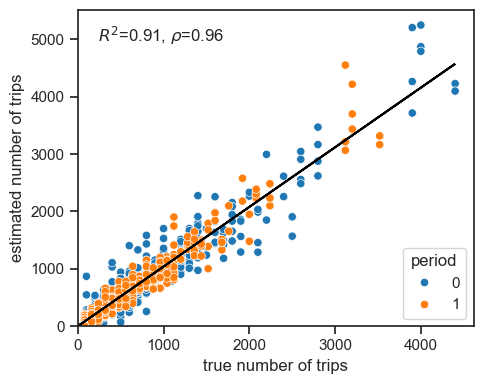

In [30]:
# Plot heatmap with flows of top od pairs
_ = plot_top_od_flows_periods(models['tvodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          reference_od=network.q.flatten(), ampm_format = False)

plt.show()

# Plot heatmaps with OD matrix
estimated_Q = models['tvodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvodlulpe.png', dpi=300)

plt.show()

In [31]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -0.83095866, 'tt_sd': -8.311537, 's': -5.3168373}
alpha =  0.59, beta  =  4.29
Avg abs diff of observed and estimated OD:  151.21
Avg observed OD:  682.95


In [32]:

metrics_df = pd.concat([models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                                 X=X, Y=Y).assign(dataset='training'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=Y,
                                                  Y=Y).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                 mape     mse       r2
component   dataset                         
equilibrium training   0.94 1.1e+04        1
flow        benchmark    31 1.8e+07 -2.9e-10
            training    4.8 3.2e+05     0.98
traveltime  benchmark    85      33  2.1e-10
            training    7.1    0.34     0.99


## c) TVGODLULPE

In [33]:
print('\ntvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions')

t0 = time.time()

models['tvgodlulpe'] = create_tvgodlulpe_model_tntp(network = network, n_periods=n_periods,
                                                    reference_g = generated_trips, features_Z=_FEATURES_Z)

train_results_dfs['tvgodlulpe'], val_results_dfs['tvgodlulpe'] = models['tvgodlulpe'].fit(
    X, Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    batch_size=_BATCH_SIZE,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric= _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs=_EPOCHS
)

print(f'\nruntime: {time.time() - t0:0.1f} [s]')

models['tvgodlulpe'].save_weights(models['tvgodlulpe']._filepath_weights)


tvgodlulpe: Time varying route choice utility and trip generation, and link specific parameters for performance functions

Model training

Link flows and travel times were pretrained with single pass of traffic assignment

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [76. 76.], coverage [t x]: [1. 1.]
Learning stage: 60 epochs

0/60: train mse=8.6e+07, train mse traveltime=6.3e+04, train mape traveltime=1101.7 train mse flow=1e+08, train mape flow=70.4, avg theta = [-1. -1. -1.], avg rr = 1.00, avg theta fixed effect = 0, loss prop od=0, total trips=[3.60e+05 2.90e+05], polynomial weights: [1.0e+00 1.0e+00 1.0e+00], lambda eq=1, relative gap=0.68, train equilibrium loss=1.6e+08, time: 0.1

1/60: train mse=3.3e+07, train mse traveltime=37, train mape traveltime=50.0 train mse flow=3.5e+07, train mape flow=41.5, avg theta = [-0.5   -1.

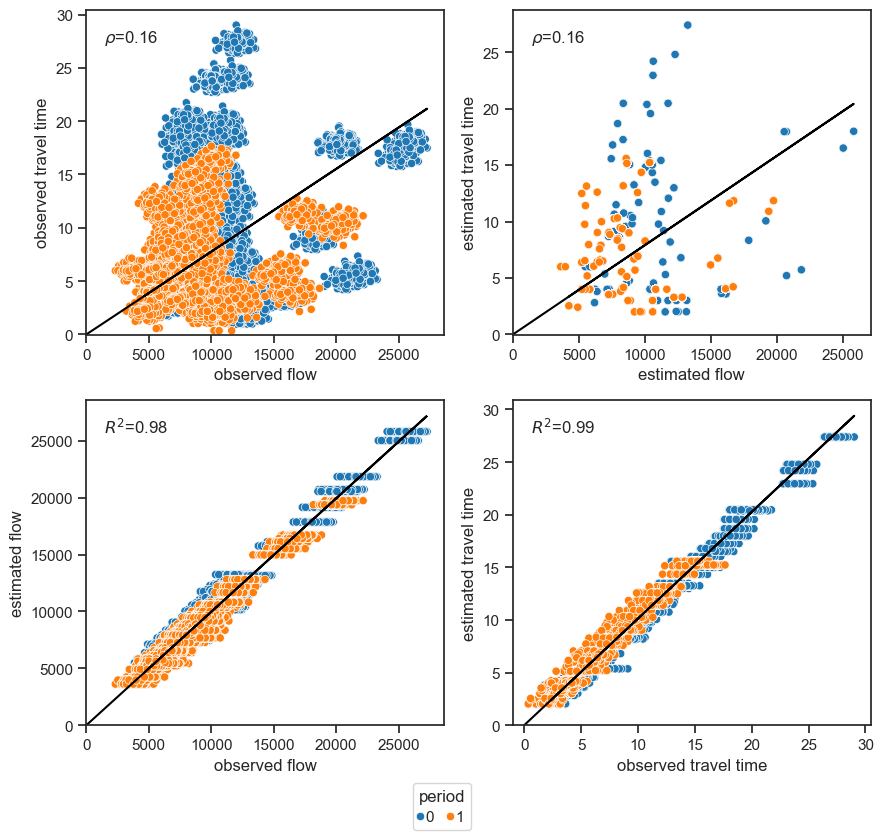

In [34]:
fig, axs = plot_flow_vs_traveltime(model = models['tvgodlulpe'],
                        observed_traveltime=Y[:, :, 0],
                        observed_flow= Y[:,:,1],
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        all_metrics = False,
                        ampm_format = False
                        )
for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-1e-2)
    ax.set_ylim(ymin=-1e-2)

axs[1,1].set_xlim(xmin=-1)

plt.savefig('output/figures/experiments/siouxfalls-scatter-flow-traveltime-tvgodlulpe.png', dpi=300)

In [35]:
flow_range = range(0, 20000, 100)
sharey = False

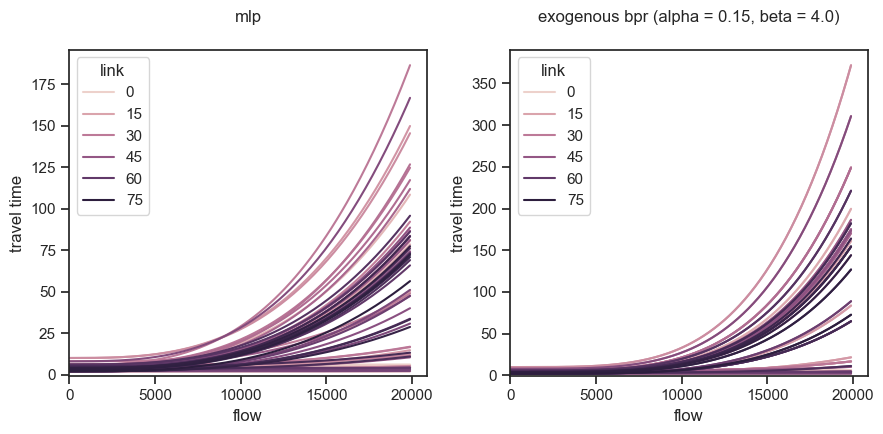

In [36]:
fig, axs = plot_performance_functions(model = models['tvgodlulpe'],
                                      network = network,
                                      marginal = False,
                                      alpha=0.15*np.ones(network.get_n_links()),
                                      beta=4*np.ones(network.get_n_links()),
                                      sharey = sharey,
                                      flow_range = flow_range
                                      )

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)
    ax.legend(loc='upper left', title = 'link')

plt.savefig('output/figures/experiments/siouxfalls-comparison-all-link-performance-functions-tvgodlulpe.png', dpi=300)

plt.show()

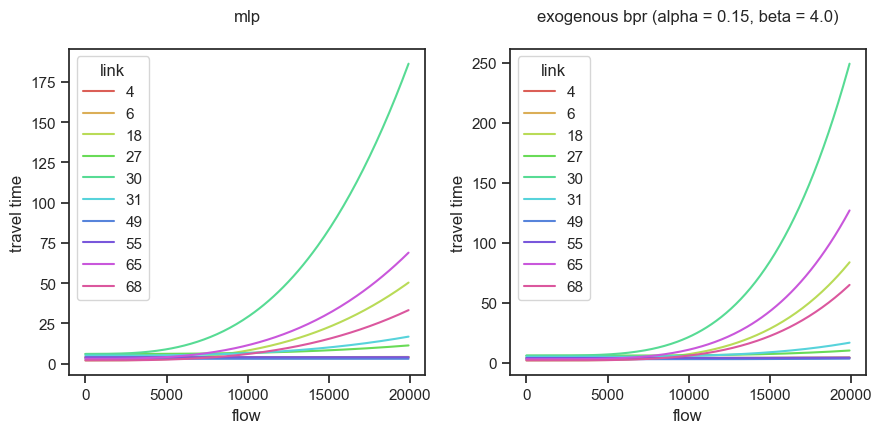

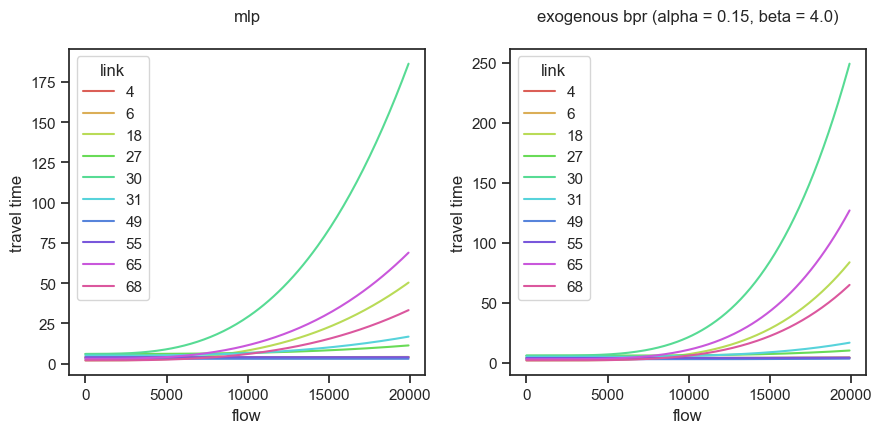

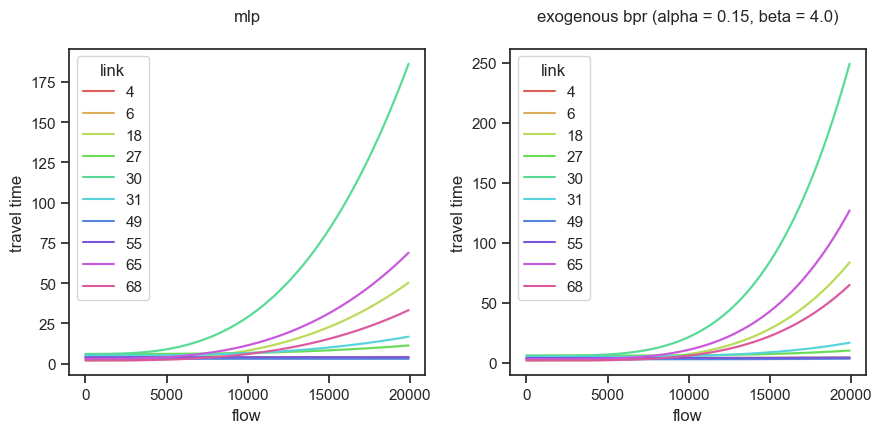

In [37]:
selected_links = np.random.choice(range(network.get_n_links()), 10, replace=False)

# Plot with bpr used the priors of the BPR parameters used to pretrain the MLP

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=False,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

# Marginal increases show that function are still monotonically increasing
plot_performance_functions(model=models['tvgodlulpe'],
                           network=network,
                           marginal=True,
                           alpha=0.15*np.ones(network.get_n_links()),
                           beta=4*np.ones(network.get_n_links()),
                           selected_links = selected_links,
                           palette = sns.color_palette("hls", len(selected_links)),
                           sharey = sharey,
                           flow_range = flow_range
                           )

plt.show()

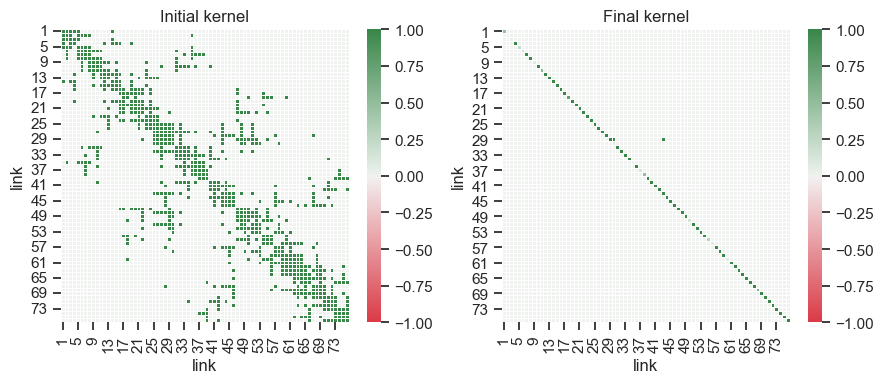

Final weights:
 [[ 0.4843  0.      0.     ...  0.      0.      0.    ]
 [ 0.      0.0157  0.     ...  0.      0.      0.    ]
 [ 0.      0.      0.0317 ...  0.      0.      0.    ]
 ...
 [ 0.      0.      0.     ...  6.8005  0.      0.    ]
 [ 0.      0.      0.     ...  0.      7.55    0.    ]
 [ 0.      0.      0.     ...  0.      0.     10.    ]]

Initial weights:
 [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [38]:
# Experiments assume no link flow interactions and that all parameters mapping flow to travel time have the same value.
# With this approach, the parameter becomes almost equal to alpha = 0.15.
# weights = models['tvgodlulpe'].performance_function.weights[1].numpy()
if models['tvgodlulpe'].performance_function.kernel_constraint.homogenous:
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].parameter.numpy()
else:
    # weights_interaction = models['tvgodlulpe'].performance_function.weights[-1].numpy()
    weights_interaction = models['tvgodlulpe'].performance_function.model.layers[0].kernel_matrix.numpy()

initial_weights = models['tvgodlulpe'].performance_function.kernel_constraint.initial_values.numpy()

plot_flow_interaction_matrix(
    flow_interaction_matrix=weights_interaction,
    masking_matrix = initial_weights,
    #flow_interaction_matrix= np.where(weights_interaction>0, 1, -1)*np.where(weights_interaction==0, 0, 1),
    #masking_matrix = np.where(initial_weights>0, 1, -1)*np.where(initial_weights==0, 0, 1),
    # vmin = -0.2, vmax = 0.2
    vmin = -1, vmax = 1
)
plt.savefig('output/figures/experiments/siouxfalls-kernel-link-performance-functions-tvgodlulpe.png', dpi=300)

plt.show()

print(f'Final weights:\n {weights_interaction}')
print(f'\nInitial weights:\n',initial_weights)

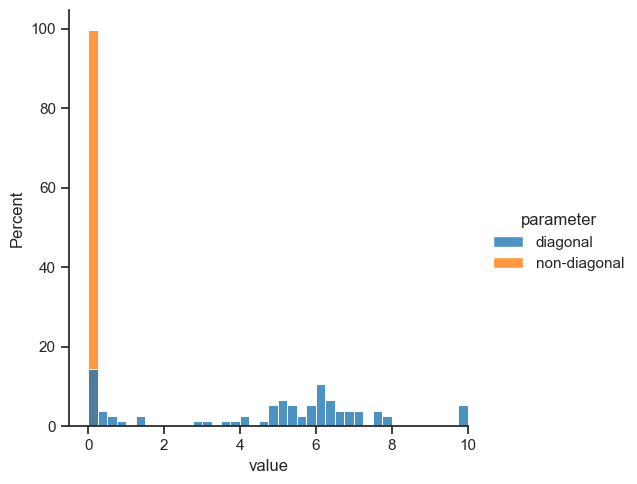

                 value  value_abs
parameter                        
diagonal      4.686005   4.686005
non-diagonal  0.004697   0.004697
              value
parameter          
diagonal         76
non-diagonal    788


In [39]:
# Distribution of weight in interaction flow matrix. Elements that are set to zero by default are excluded from non-diagonal
plot_data = pd.concat([pd.DataFrame({'value': tf.linalg.diag_part(weights_interaction).numpy().flatten(), 'parameter': 'diagonal'}),
                                  pd.DataFrame({'value': weights_interaction[np.where(~np.eye(weights_interaction.shape[0],dtype=bool)*models['tvgodlulpe'].performance_function.kernel_constraint.adjacency_constraint_matrix)], 'parameter': 'non-diagonal'})])

plot_data['value_abs'] = plot_data.value.abs()

# sns.displot(data = plot_data, x="value", col="type", kind="hist", hue = "type", alpha=0.8, facet_kws=dict(sharey=False, sharex = False))
# plt.show()

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,4))
# sns.histplot(plot_data, x="value", stat='density', hue="parameter", alpha = 0.8, multiple="stack", ax = ax)
try:
    sns.displot(data = plot_data, x="value", kind="hist", stat='percent', common_norm=False, hue = "parameter", alpha=0.8,
                facet_kws=dict(sharey=False, sharex = False), binwidth = 0.25)
    plt.xlim(-0.5, 10)
    plt.savefig('output/figures/experiments/siouxfalls-distribution-link-performance-parameters-tvgodlulpe.png', dpi=300)
    plt.show()
except:
    print('Distribution plot could not be shown')
print(plot_data.groupby('parameter')[['value', 'value_abs']].mean())
print(plot_data.groupby('parameter')[['value']].count())

In [40]:
# Weight of polynomial
print(f"polynomial weights {tf.reduce_mean(models['tvgodlulpe'].performance_function.polynomial_layer.poly_weights,0).numpy()}")

polynomial weights [0.0002 0.0012 0.0448]


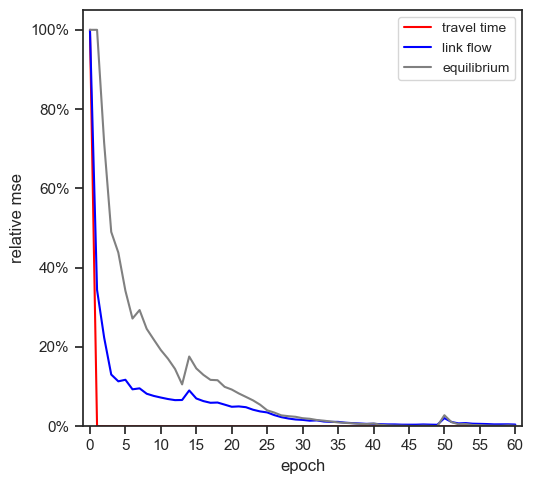

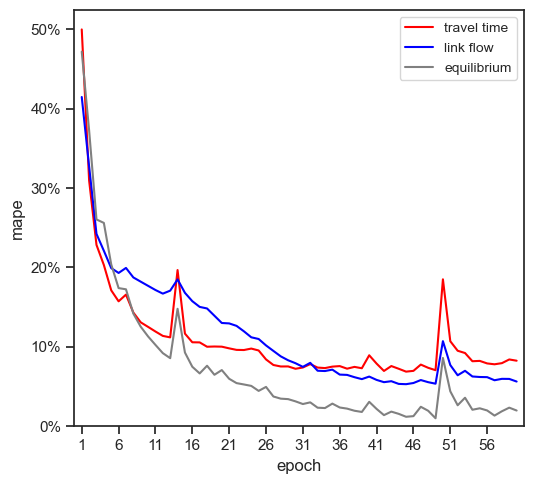

In [41]:
plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            xticks_spacing=5,
                            epochs_end_learning_stage=_EPOCHS['learning'])

plt.savefig('output/figures/experiments/siouxfalls-relative-mse-tvgodlulpe.png', dpi=300)

plot_predictive_performance(train_losses=train_results_dfs['tvgodlulpe'][train_results_dfs['tvgodlulpe'].epoch>0],
                            val_losses=val_results_dfs['tvgodlulpe'], show_validation=False,
                            show_percentage_units = True,
                            xticks_spacing=5, epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape')

plt.savefig('output/figures/experiments/siouxfalls-mape-tvgodlulpe.png', dpi=300)

plt.show()

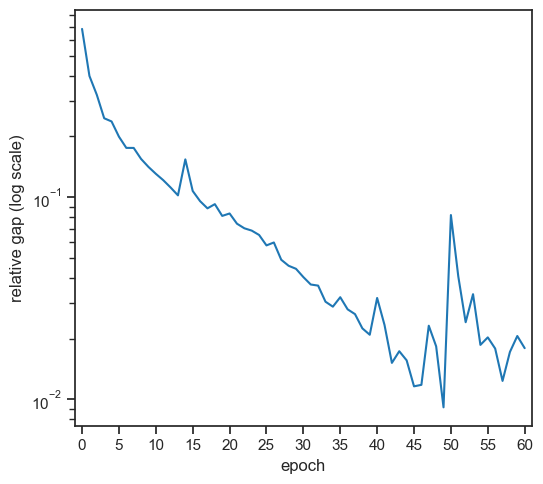

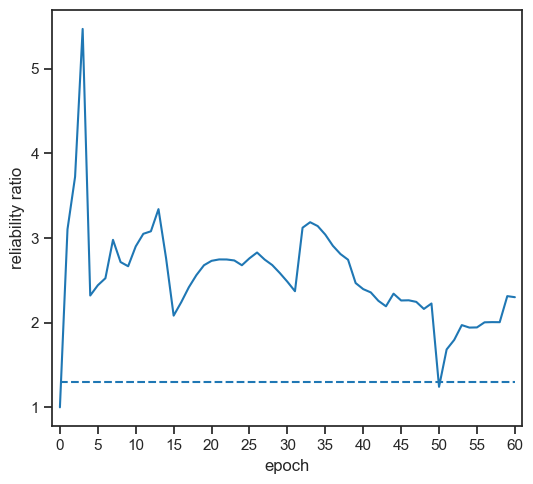

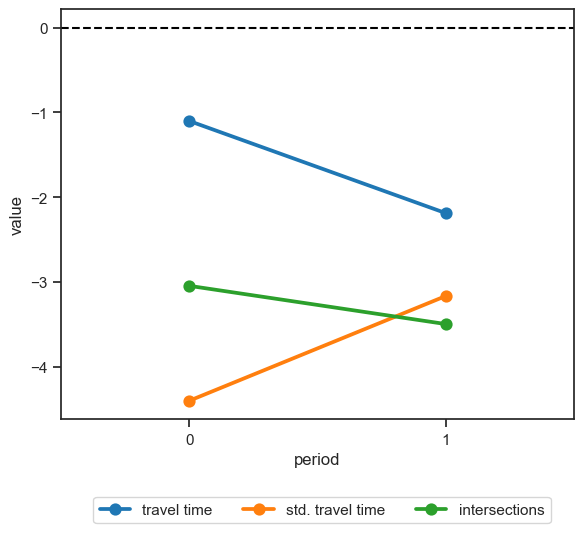

   period         parameter     value    group
0       0       travel time -1.100775  utility
1       1       travel time -2.187923  utility
2       0  std. travel time -4.401657  utility
3       1  std. travel time -3.165844  utility
4       0     intersections -3.046012  utility
5       1     intersections -3.496947  utility


In [42]:
fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvgodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvgodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=5)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')
ax.get_legend().remove()

plt.savefig('output/figures/experiments/siouxfalls-relative-gap-tvgodlulpe.png', dpi=300)

plt.show()

fig, ax = plot_convergence_estimates(estimates=train_results_dfs['tvgodlulpe']. \
                                     assign(rr=train_results_dfs['tvgodlulpe']['tt_sd'] / train_results_dfs['tvgodlulpe']['tt'])[['epoch', 'rr']],
                                     true_values={'rr': models['tvgodlulpe'].utility.true_values['tt_sd']/models['tvgodlulpe'].utility.true_values['tt']},
                                     xticks_spacing=5)
ax.get_legend().remove()
ax.set_ylabel("reliability ratio")
plt.show()

# Utility by period
theta_df = plot_utility_parameters_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature='hour', plot = False).reset_index().drop(['hour','index'], axis = 1).reset_index().rename(columns = {'index':'period'})

theta_df = pd.melt(theta_df, id_vars = 'period', var_name = 'parameter').assign(group = 'utility').replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections'})

fig, axs = plot_parameters(df = theta_df, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig(f'output/figures/experiments/siouxfalls-utility-periods-tvgodlulpe.png', dpi=300)

plt.show()

print(theta_df)

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:935: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(data=total_trips_by_hour, x=period_feature, y='total_trips', ax=ax,


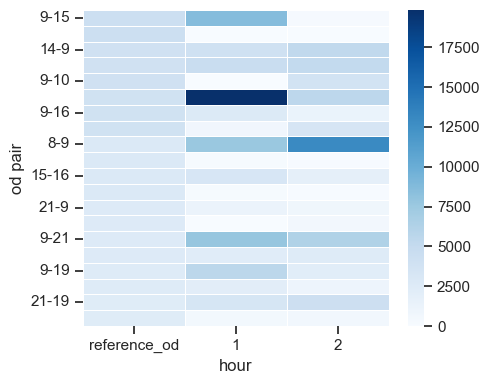

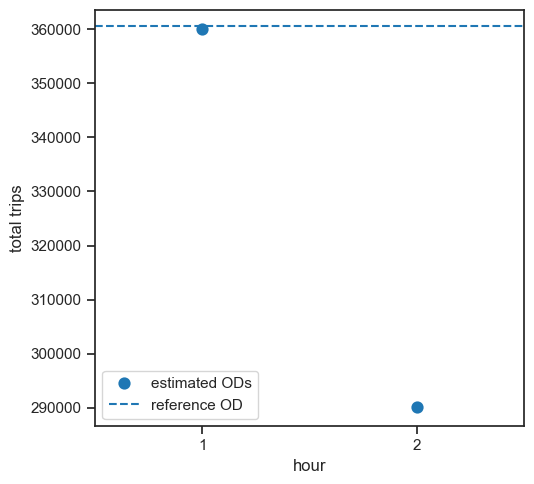

In [43]:
# Plot heatmap with flows of top od pairs
q_df = plot_top_od_flows_periods(models['tvgodlulpe'], period_keys=period_keys, period_feature=period_feature, top_k=20,
                          reference_od=network.q, ampm_format = False)
plt.show()

period 0

correlation: 0.4438248521269565


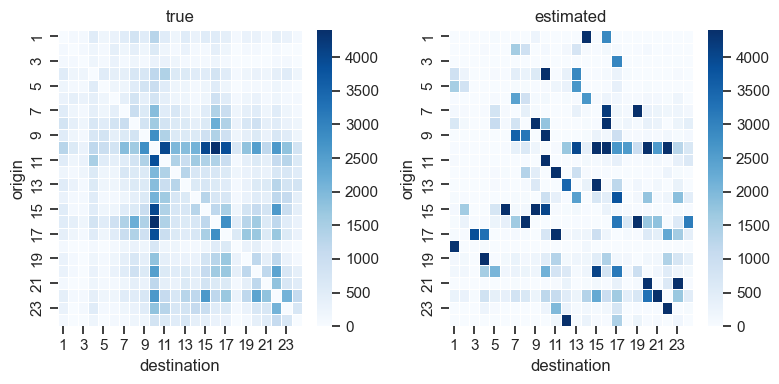

period 1

correlation: 0.48486698835509773


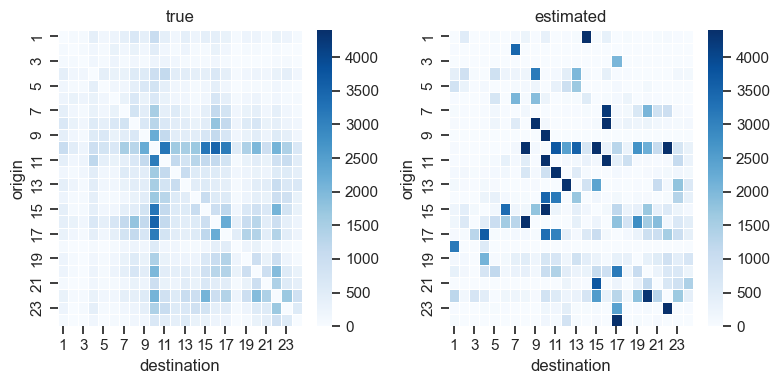

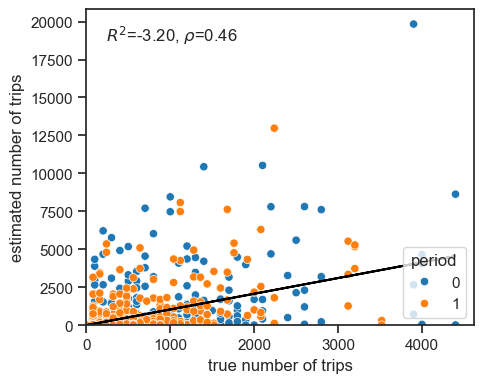

In [44]:
estimated_Q = models['tvgodlulpe'].Q.numpy()
plot_data = pd.DataFrame()

for period in range(estimated_Q.shape[0]):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'estimated': estimated_Q[period]}  # 'historic': Q_historic,

    rho_val, p = sp.stats.pearsonr(Qs["true"].flatten(), Qs["estimated"].flatten())
    print(f'correlation: {rho_val}')

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))
    plt.show()

    plot_data = pd.concat([plot_data, pd.DataFrame({'true': Qs['true'].flatten(), 'estimated':Qs['estimated'].flatten(),
                                                    'period': period})])

fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
sns.scatterplot(data=plot_data, x='true', y='estimated', hue = 'period', ax = ax)
plot_annotate_r2(ax=ax, x=plot_data['true'], y=plot_data['estimated'], intercept = False, r2 = True, rho = True)
ax.set_xlabel('true number of trips')
ax.set_ylabel('estimated number of trips')
ax.legend(loc='lower right', title = 'period')
ax.set_xlim(xmin=-1e-2)
ax.set_ylim(ymin=-1e-2)

plt.savefig(f'output/figures/experiments/siouxfalls-scatter-ode-tvgodlulpe.png', dpi=300)

plt.show()

In [45]:
print(f"theta = "
      f"{dict(zip(models['tvgodlulpe'].utility.true_values.keys(), list(np.mean(models['tvgodlulpe'].theta.numpy(), axis=0))))}")
if models['tvgodlulpe']._kappa is not None:
    print(f"kappa= "
          f"{dict(zip(models['tvgodlulpe'].generation.features, list(np.mean(models['tvgodlulpe'].kappa.numpy(), axis=0))))}")
print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvgodlulpe'].q - network.q.flatten())): 0.2f}")
print(f"Avg observed OD: {np.mean(np.abs(network.q.flatten())): 0.2f}")

theta = {'tt': -1.6443493, 'tt_sd': -3.7837508, 's': -3.2714791}
Avg abs diff of observed and estimated OD:  718.75
Avg observed OD:  682.95


In [46]:
metrics_df = pd.concat([models['tvgodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score},
                                                  X=X, Y=Y).assign(dataset='training'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, Y_ref=Y,
                                                  Y=Y).assign(dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                 mape     mse       r2
component   dataset                         
equilibrium training      2 7.9e+04        1
flow        benchmark    31 1.8e+07 -2.9e-10
            training    5.6 4.3e+05     0.98
traveltime  benchmark    85      33  2.1e-10
            training    8.3    0.45     0.99


### Predictive performance

In [47]:
inference_model = create_tvgodlulpe_model_tntp(network=network, n_periods=n_periods, features_Z=_FEATURES_Z,
                                               reference_g = generated_trips, reference_q = q_historic)
inference_model.build()
inference_model.load_weights(models['tvgodlulpe']._filepath_weights)

In [48]:
_ = inference_model.predict(X,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        batch_size= None,
                        optimizer= tf.keras.optimizers.legacy.Adam(learning_rate=1e-1),
                        loss_weights={'equilibrium': 1},
                        pretrain_link_flows = False,
                        threshold_relative_gap=_RELATIVE_GAP,
                        epochs=200)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    print(inference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2_score}, X=X, Y=Y))


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 2, batch size: 300, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: nan, coverage [t x]: nan

0/200: train mse=7.9e+04, avg theta = [-1.644 -3.784 -3.271], avg rr = 2.30, avg theta fixed effect = -0.2, loss prop od=0, total trips=[3.60e+05 2.90e+05], polynomial weights: [1.6e-04 1.2e-03 4.5e-02], lambda eq=1, relative gap=0.018, train equilibrium loss=7.9e+04, time: 0.1

Relative gap threshold of inf was achieved in equilibrium stage


     component    value metric
0         flow     5.63   mape
1   traveltime     8.26   mape
2  equilibrium     1.98   mape
0         flow 4.34e+05    mse
1   traveltime    0.451    mse
2  equilibrium  7.9e+04    mse
0         flow    0.975     r2
1   traveltime    0.986     r2
2  equilibrium    0.996     r2


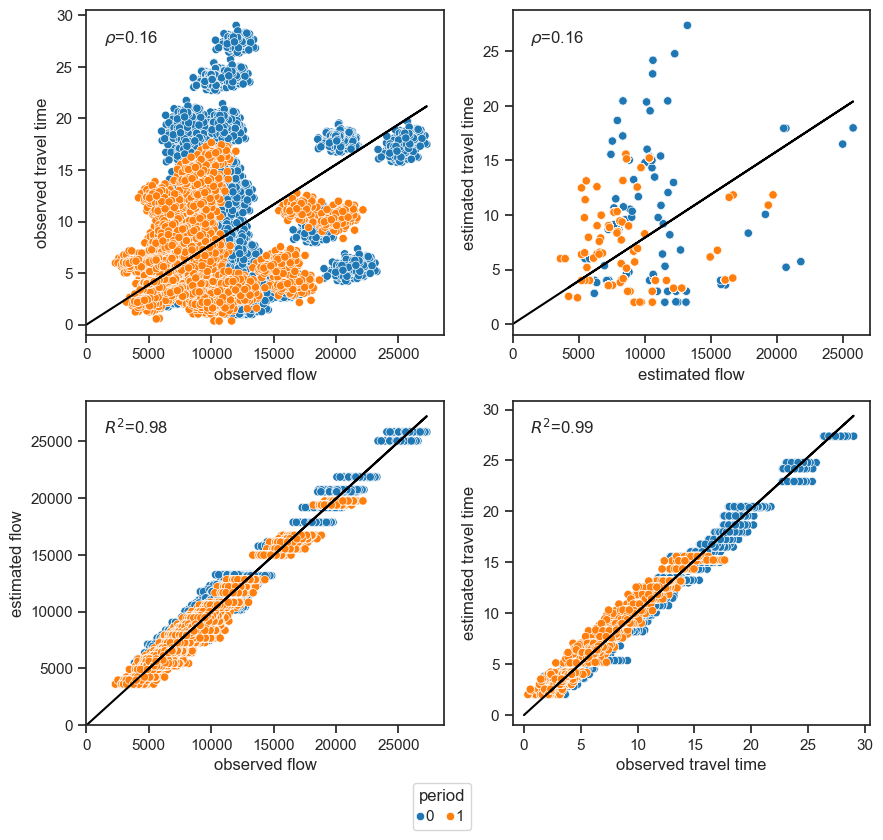

In [49]:
fig, axs = plot_flow_vs_traveltime(model = inference_model,
                        observed_traveltime=inference_model.mask_observed_traveltime(Y[:, :, 0]),
                        observed_flow= inference_model.mask_observed_flow(Y[:,:,1]),
                        period_col = X[:,:,-1].numpy().astype(int).flatten(),
                        ampm_format = False,
                        all_metrics = False)

for ax in axs.reshape(-1):
    ax.set_xlim(xmin=-10)
    ax.set_ylim(ymin=-1)

axs[1,1].set_xlim(xmin=-1)

plt.show()

## c) Comparisons

### i) ODE

period 0



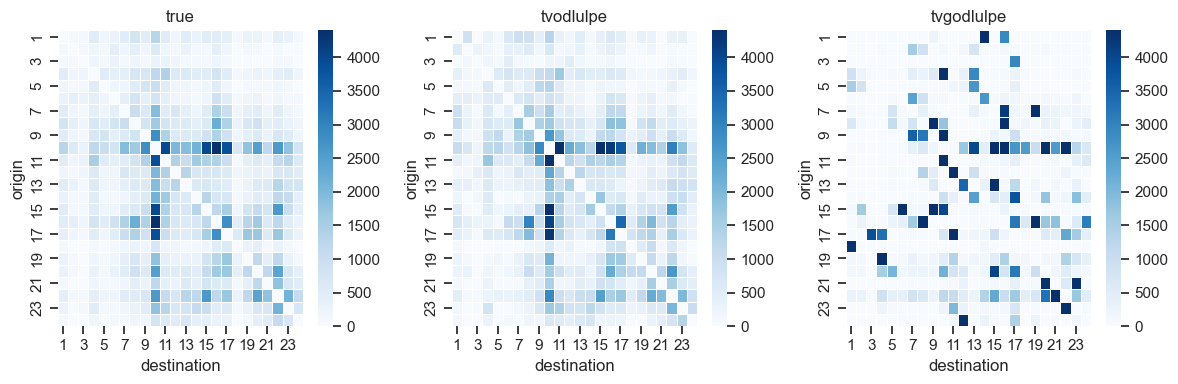

period 1



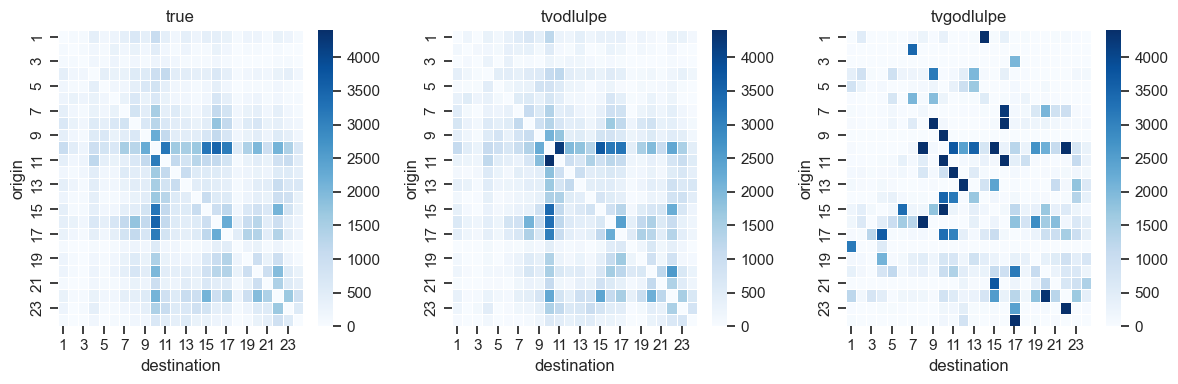

In [50]:
for period in range(n_periods):
    print(f'period {period}\n')
    Qs = {'true': Q_true[period], 'tvodlulpe': models['tvodlulpe'].Q.numpy()[period], 'tvgodlulpe': models['tvgodlulpe'].Q.numpy()[period]}  # 'historic': Q_historic,

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Q_true[0]), vmax=np.max(Q_true[0]), subplots_dims=(1, len(Qs.keys())),
                         figsize=(4*len(Qs.keys()), 4))

    plt.savefig(f'output/figures/experiments/siouxfalls-comparison-heatmaps-ode-period-{period}.png', dpi=300)

    plt.show()

## K-Fold Cross Validation

In [51]:
_MLP_KFOLD = create_mlp_tntp(network=network, diagonal=True, homogenous=True, poly_order = _POLY_ORDER, dtype=_DTYPE, pretrain = False, link_specific = False)

# It is important to initialize utility around true values, in this case we choose to initialize with the prior signs.
_UTILITY_KFOLD = UtilityParameters(features_Y=['tt'],
                                   features_Z=_FEATURES_Z,
                                   initial_values={
                                       'tt': -1, 'tt_sd': -1, 's': -1, 'psc_factor': 0,
                                                   'fixed_effect': np.zeros_like(network.links)},
                                   trainables={'tt': True, 'tt_sd': True, 's': True,
                                               'psc_factor': False, 'fixed_effect': False},
                                   time_varying=True,
                                   dtype=_DTYPE
                                   )

In [52]:
models_kfold = {}
metrics_kfold = {}
parameters_kfold = {}

### a) Comparison between MLP and BPR assuming known utility and OD

#### i) MLP

In [53]:
models_kfold['tvlpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    reference_g= generated_trips,
    performance_function = _MLP_KFOLD,
    utility = False,
    features_Z= _FEATURES_Z,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
)[0]

metrics_kfold['tvlpe-mlp'], parameters_kfold['tvlpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlpe-mlp'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-mlp_{network_name}.csv")

2023-12-22 16:11:35.080391: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.4e+07    mse
1  traveltime      24    mse
0        flow      29  mdape
1  traveltime      80  mdape
0        flow  -0.046     r2
1  traveltime   -0.92     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=5e+07, train mse traveltime=5e+04, train mape traveltime=795.6 train mse flow=4.4e+07, train mape flow=54.4, val mse=4.5e+07, val mse traveltime=8.1e+03, val ma

In [54]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    # print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
    #       groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
    #       aggregate(['mean', 'std']))
    print(metrics_kfold['tvlpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                                median     mean     std
dataset    component   metric stage                                    
training   equilibrium mape   final                1.4      1.3    0.39
                              initial          1.1e+02  1.1e+02       0
                       mdape  final               0.87     0.85    0.24
                              initial               64       64       0
                       mse    final              5e+04  4.3e+04 2.5e+04
...                                                ...      ...     ...
validation traveltime  mse    historical mean       36       37      13
                              initial          2.7e+04  4.1e+04 4.5e+04
                       r2     final               0.94     0.92   0.057
                              historical mean    -0.12    -0.43    0.52
                              initial         -7.9e+02 -1.6e+03 1.7e+03

[64 rows x 3 columns]


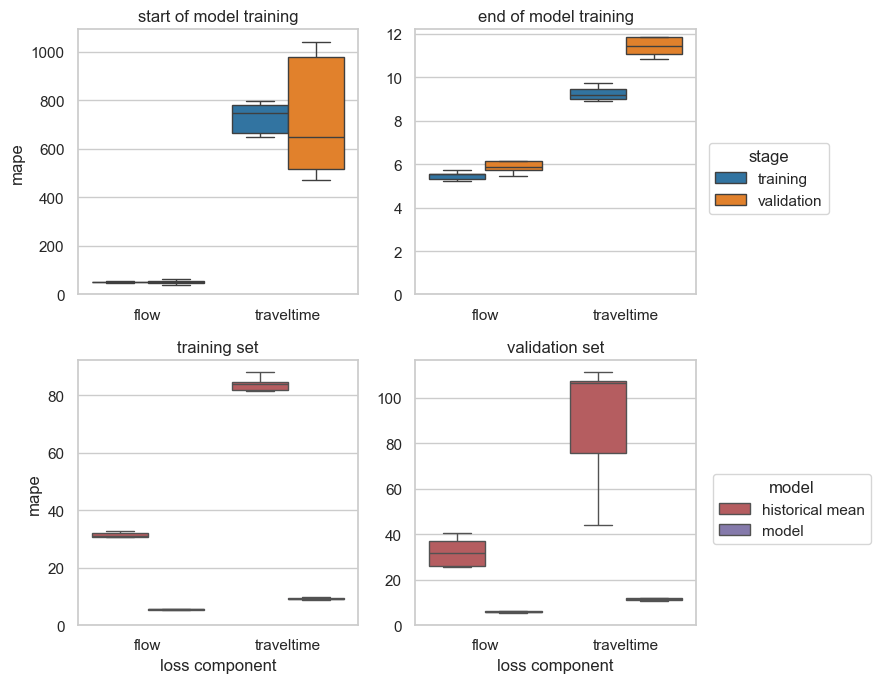

In [55]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-mlp.png', dpi=300)

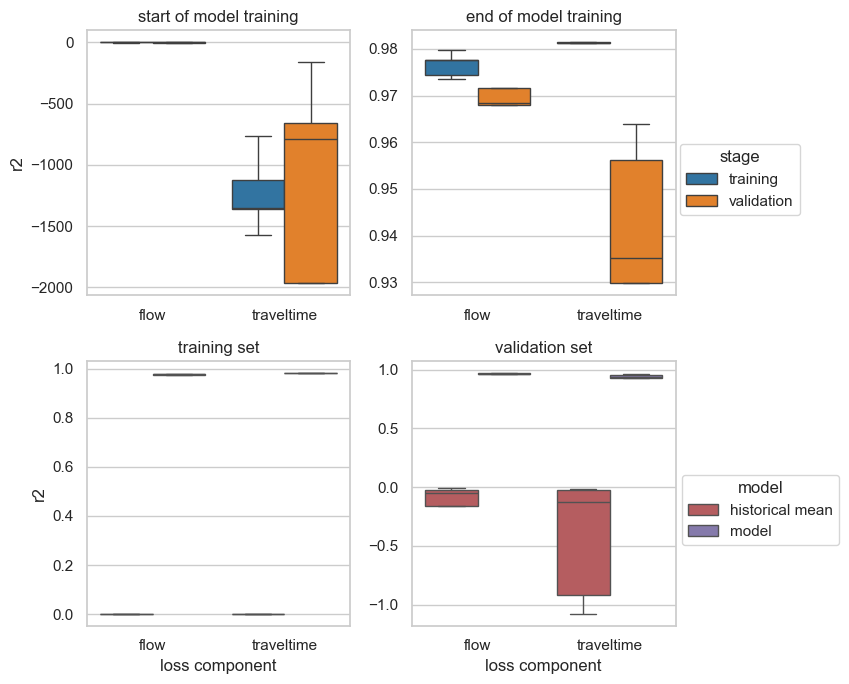

In [56]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-mlp'][metrics_kfold['tvlpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)
plt.show()

#### ii) BPR

In [57]:
models_kfold['tvlpe-bpr'] = create_model_tntp(
    n_periods=n_periods, network=network,
    reference_g=generated_trips,
    performance_function = create_bpr(network = network, dtype = _DTYPE),
    utility = False,
    features_Z=_FEATURES_Z,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,

)[0]

metrics_kfold['tvlpe-bpr'], parameters_kfold['tvlpe-bpr'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlpe-bpr'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval= _EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlpe-bpr'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlpe-bpr_{network_name}.csv")


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.4e+07    mse
1  traveltime      24    mse
0        flow      29  mdape
1  traveltime      80  mdape
0        flow  -0.046     r2
1  traveltime   -0.92     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=1.5e+07, train mse traveltime=23, train mape traveltime=40.1 train mse flow=4.5e+06, train mape flow=14.2, val mse=1.5e+07, val mse traveltime=10, val mape tr

In [58]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(metrics_kfold['tvlpe-bpr']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                               median    mean     std
dataset    component   metric stage                                  
training   equilibrium mape   final               6.8     6.2     2.7
                              initial              57      57       0
                       mdape  final                 2     2.1    0.57
                              initial              33      33       0
                       mse    final           1.2e+06 2.6e+06 3.9e+06
...                                               ...     ...     ...
validation traveltime  mse    historical mean      36      37      13
                              initial              19      21     8.4
                       r2     final             -0.32    -0.4    0.74
                              historical mean   -0.12   -0.43    0.52
                              initial            0.21    0.21    0.27

[64 rows x 3 columns]


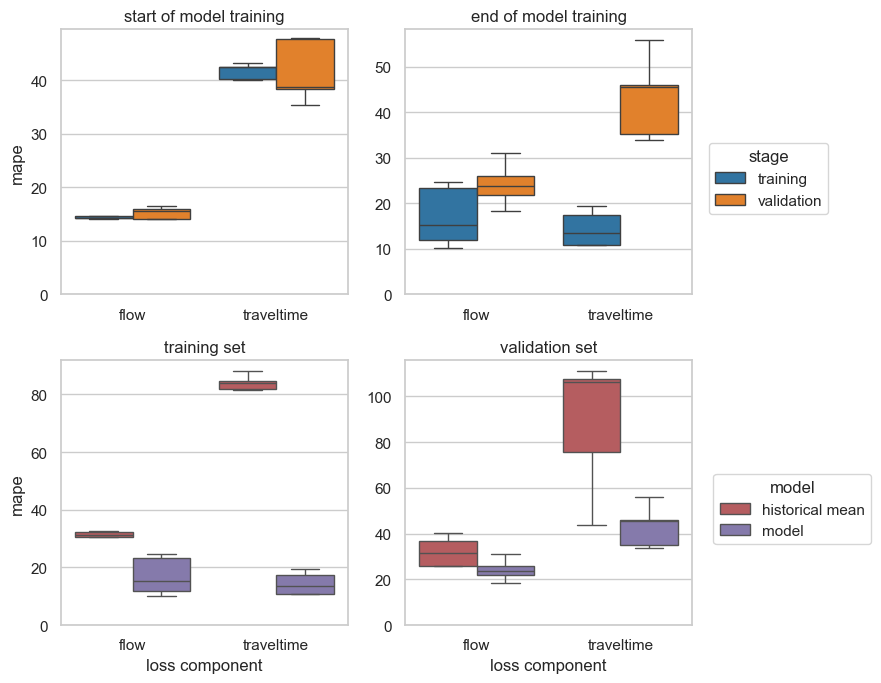

In [59]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)
plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvlpe-bpr.png', dpi=300)

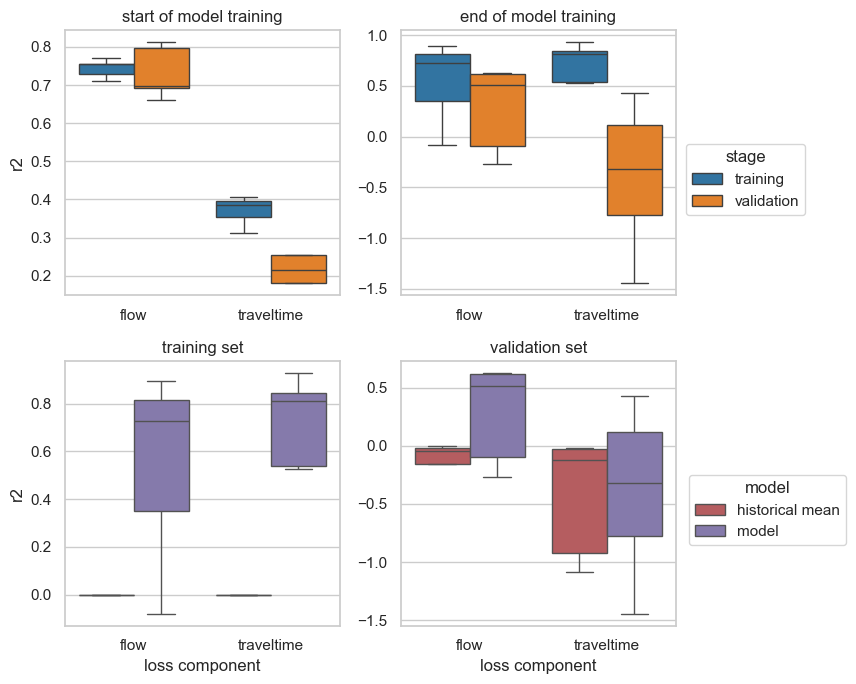

In [60]:
plot_metrics_kfold(df=metrics_kfold['tvlpe-bpr'][metrics_kfold['tvlpe-bpr'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey=False)
plt.show()

### b) Impact of estimating utility function

In [61]:
models_kfold['tvlulpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    performance_function = _MLP_KFOLD,
    utility = True,
    utility_parameters=_UTILITY_KFOLD,
    od_parameters = ODParameters(key='od',
                             initial_values= q_true,
                             ods=network.ods,
                             n_nodes = len(network.nodes),
                             n_periods=n_periods,
                             time_varying=True,
                             trainable=False),
    generation = False,
      # reference_g= generated_trips,
)[0]

metrics_kfold['tvlulpe-mlp'], parameters_kfold['tvlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model= models_kfold['tvlulpe-mlp'],
    X=X, Y=Y,
    optimizers= _OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric = _LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs= _EPOCHS_KFOLD
)

metrics_kfold['tvlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvlulpe-mlp_{network_name}.csv")


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.4e+07    mse
1  traveltime      24    mse
0        flow      29  mdape
1  traveltime      80  mdape
0        flow  -0.046     r2
1  traveltime   -0.92     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=5.3e+07, train mse traveltime=1.1e+05, train mape traveltime=899.0 train mse flow=5e+07, train mape flow=53.3, val mse=4.4e+07, val mse traveltime=1.5e+03, va

In [62]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(metrics_kfold['tvlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                                median     mean     std
dataset    component   metric stage                                    
training   equilibrium mape   final                1.6      1.6    0.29
                              initial          1.1e+02  1.1e+02       0
                       mdape  final                  1        1    0.24
                              initial               48       48       0
                       mse    final            3.7e+04  4.6e+04 2.7e+04
...                                                ...      ...     ...
validation traveltime  mse    historical mean       36       37      13
                              initial          2.5e+04  8.8e+04 1.2e+05
                       r2     final               0.96     0.95   0.027
                              historical mean    -0.12    -0.43    0.52
                              initial         -7.3e+02 -3.4e+03 4.7e+03

[64 rows x 3 columns]


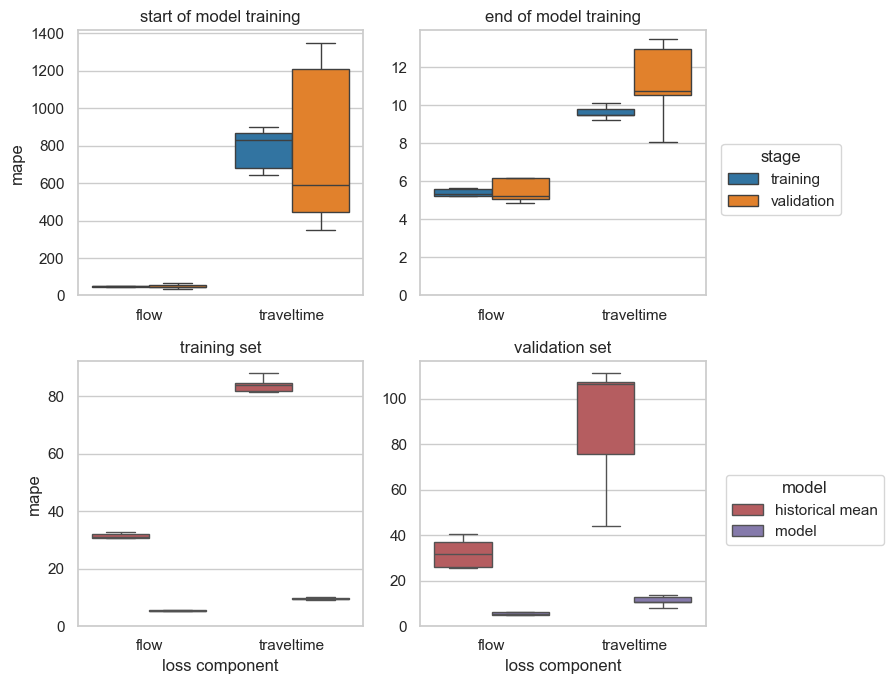

In [63]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'mape', showfliers = False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

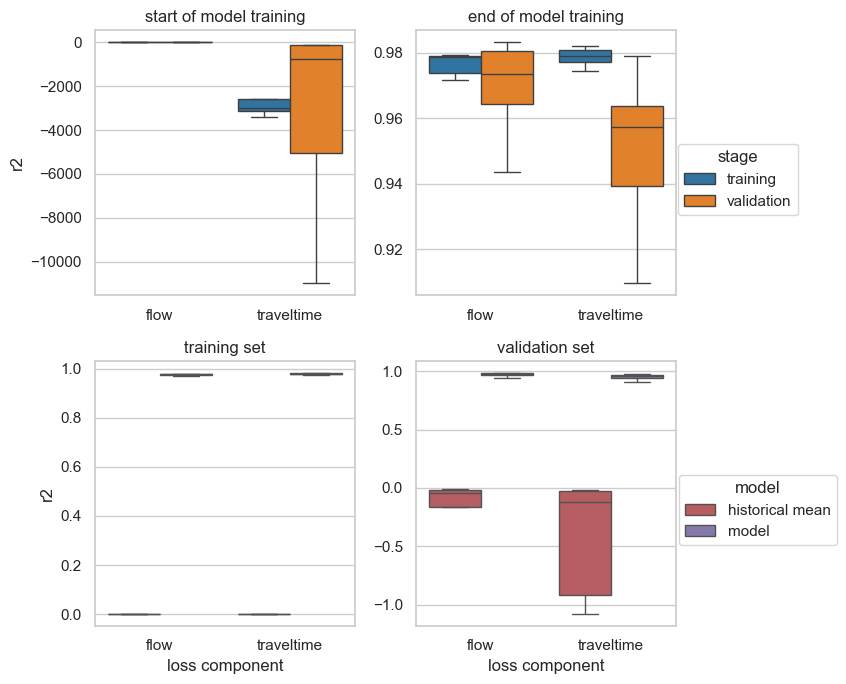

In [64]:
plot_metrics_kfold(df=metrics_kfold['tvlulpe-mlp'][metrics_kfold['tvlulpe-mlp'].component.isin(['flow', 'traveltime'])], metric_name = 'r2', showfliers = False, sharey = False)
plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:200: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=df, x=x_label, y='value', hue='parameter', ax=axs, **kwargs)


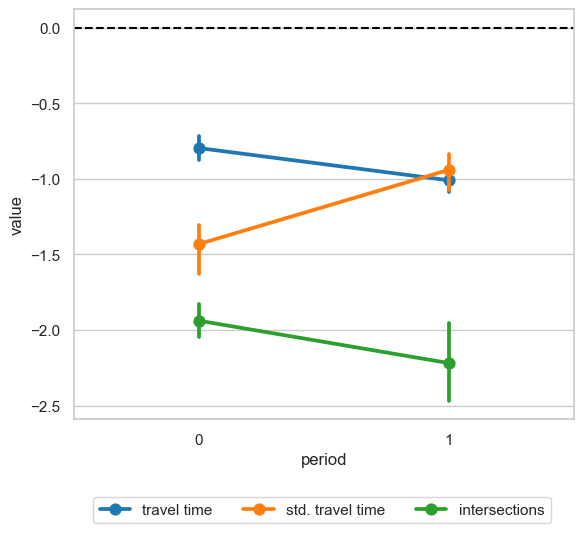

In [65]:
parameters_kfold['tvlulpe-mlp']['hour'] = parameters_kfold['tvlulpe-mlp'].period.replace({v: k for k, v in models_kfold['tvlulpe-mlp'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvlulpe-mlp']['parameter'] = parameters_kfold['tvlulpe-mlp']['parameter'].replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvlulpe-mlp'] = parameters_kfold['tvlulpe-mlp'][parameters_kfold['tvlulpe-mlp'].parameter != 'reliability ratio']

fig, axs = plot_parameters_kfold(df = parameters_kfold['tvlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvgodlulpe.png', dpi=300)

### c) Effect of OD estimation method

#### i) Traditional ODE with reference O-D matrix to initialize parameters and MLP function

In [66]:
models_kfold['tvodlulpe-mlp'] = create_model_tntp(
    n_periods=n_periods, network=network,
    model_key = 'tvgodlulpe',
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=False,
    od_parameters=ODParameters(key='od',
                               initial_values=q_true,
                               reference_values={0: q_historic[0], 1:q_historic[1]},
                               ods=network.ods,
                               n_nodes = len(network.nodes),
                               n_periods=n_periods,
                               time_varying=True,
                               trainable=True),

)[0]

metrics_kfold['tvodlulpe-mlp'], parameters_kfold['tvodlulpe-mlp'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model=models_kfold['tvodlulpe-mlp'],
    X=X, Y=Y,
    optimizers=_OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs=_EPOCHS_KFOLD
)
metrics_kfold['tvodlulpe-mlp'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvodlulpe-mlp_{network_name}.csv")


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.4e+07    mse
1  traveltime      24    mse
0        flow      29  mdape
1  traveltime      80  mdape
0        flow  -0.046     r2
1  traveltime   -0.92     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=5.3e+07, train mse traveltime=1.1e+05, train mape traveltime=899.0 train mse flow=5e+07, train mape flow=53.3, val mse=4.4e+07, val mse traveltime=1.5e+03, va

In [67]:

with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(metrics_kfold['tvodlulpe-mlp']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                                median     mean     std
dataset    component   metric stage                                    
training   equilibrium mape   final                1.1     0.98    0.18
                              initial          1.1e+02  1.1e+02       0
                       mdape  final               0.72     0.71    0.21
                              initial               48       48       0
                       mse    final            2.3e+04    2e+04 8.6e+03
...                                                ...      ...     ...
validation traveltime  mse    historical mean       36       37      13
                              initial          2.5e+04  8.8e+04 1.2e+05
                       r2     final               0.71     0.42    0.63
                              historical mean    -0.12    -0.43    0.52
                              initial         -7.3e+02 -3.4e+03 4.7e+03

[64 rows x 3 columns]


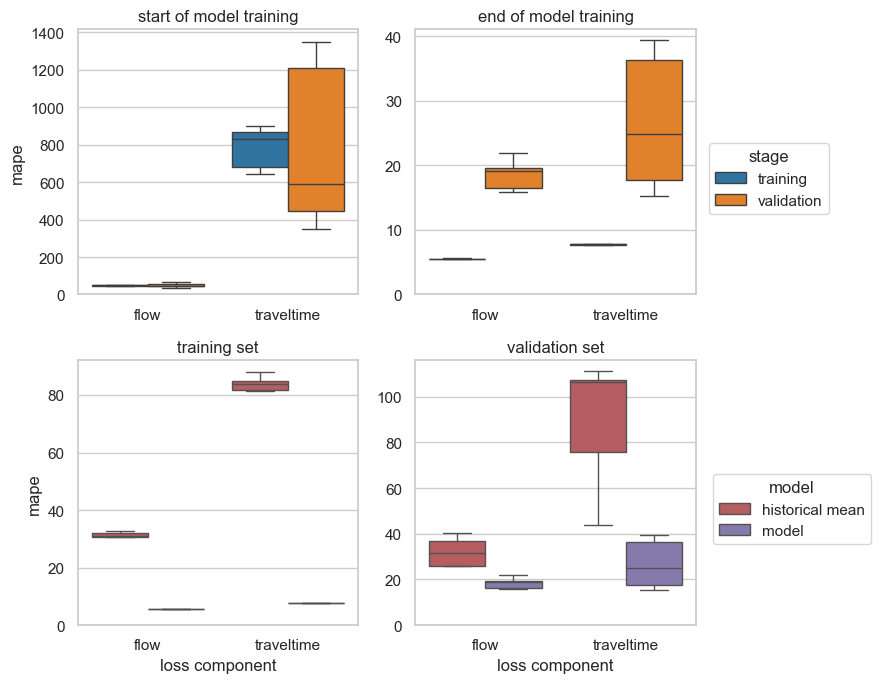

In [68]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvodlulpe-mlp.png', dpi=300)

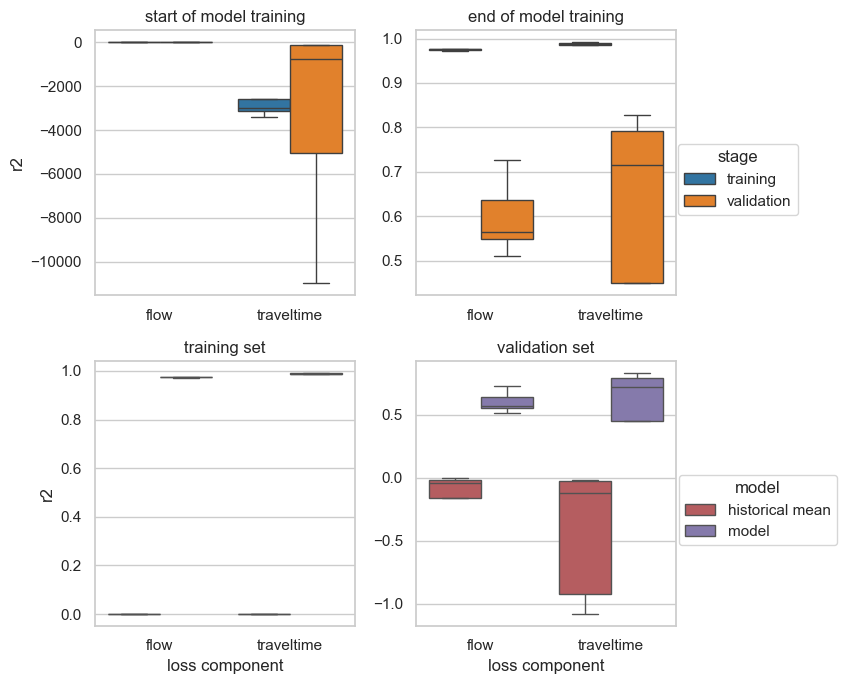

In [69]:
plot_metrics_kfold(df=metrics_kfold['tvodlulpe-mlp'][metrics_kfold['tvodlulpe-mlp'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)
plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:200: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=df, x=x_label, y='value', hue='parameter', ax=axs, **kwargs)


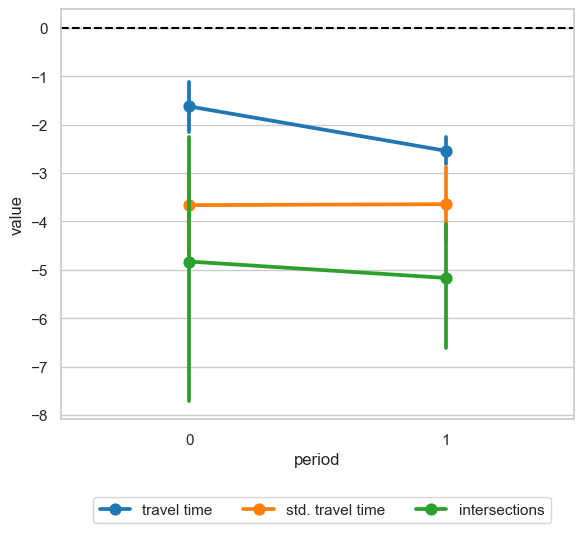

In [70]:
parameters_kfold['tvodlulpe-mlp']['parameter'] = parameters_kfold['tvodlulpe-mlp']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 's': 'intersections', 'vot': 'reliability ratio'})

parameters_kfold['tvodlulpe-mlp'] = parameters_kfold['tvodlulpe-mlp'][parameters_kfold['tvodlulpe-mlp'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvodlulpe-mlp'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvodlulpe-mlp', dpi = 300)

plt.show()

#### ii) ODE with generation stage, with access to reference trip generation matrix for initialization and with MLP function

In [71]:
models_kfold['tvgodlulpe'] = create_model_tntp(
    n_periods=n_periods, network=network,
    performance_function= _MLP_KFOLD,
    utility=True,
    utility_parameters=_UTILITY_KFOLD,
    generation=True,
    reference_g=generated_trips
)[0]

metrics_kfold['tvgodlulpe'], parameters_kfold['tvgodlulpe'] = train_kfold(
    n_splits=_N_SPLITS,
    random_state=_SEED,
    model=models_kfold['tvgodlulpe'],
    X=X, Y=Y,
    optimizers=_OPTIMIZERS,
    node_data=node_data,
    loss_weights= _LOSS_WEIGHTS_KFOLD,
    loss_metric=_LOSS_METRIC,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=_BATCH_SIZE,
    epochs_print_interval=_EPOCHS_KFOLD.copy(),
    epochs=_EPOCHS_KFOLD
)

metrics_kfold['tvgodlulpe'].to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_tvgodlulpe-mlp_{network_name}.csv")


Fold 1/5

Model training

Link flows and travel times were pretrained with single pass of traffic assignment
Benchmark metrics using historical mean in training data to make predictions in the validation set: 


    component   value metric
0        flow      37   mape
1  traveltime 1.1e+02   mape
0        flow 1.4e+07    mse
1  traveltime      24    mse
0        flow      29  mdape
1  traveltime      80  mdape
0        flow  -0.046     r2
1  traveltime   -0.92     r2

hyperparameters loss function: {'od': 0, 'traveltime': 1, 'flow': 1, 'equilibrium': 1.0}

number of periods: 2, batch size: 1, threshold relative gap: inf
training set -> timepoints: 300, obs [t x]: [60. 60.], coverage [t x]: [0.79 0.79]
validation set -> timepoints: 300, obs [t x]: [16. 16.], coverage [t x]: [0.21 0.21]

Learning stage: 60 epochs

0/60: train mse=9.2e+07, train mse traveltime=7.8e+04, train mape traveltime=1245.4 train mse flow=1.2e+08, train mape flow=75.5, val mse=6.3e+07, val mse traveltime=6.6e+03,

In [72]:
with pd.option_context('display.float_format', '{:0.2g}'.format):
    print(metrics_kfold['tvgodlulpe']. \
          groupby(['dataset', 'component', 'metric', 'stage'])['value']. \
          aggregate(['median', 'mean', 'std']))

                                                median     mean     std
dataset    component   metric stage                                    
training   equilibrium mape   final                1.7      1.7    0.16
                              initial          1.1e+02  1.1e+02       0
                       mdape  final                1.2      1.1    0.31
                              initial               58       58       0
                       mse    final            7.3e+04  9.5e+04 5.8e+04
...                                                ...      ...     ...
validation traveltime  mse    historical mean       36       37      13
                              initial          6.1e+04  6.4e+04 5.3e+04
                       r2     final               -1.5     -1.4     1.5
                              historical mean    -0.12    -0.43    0.52
                              initial         -1.5e+03 -2.3e+03   2e+03

[64 rows x 3 columns]


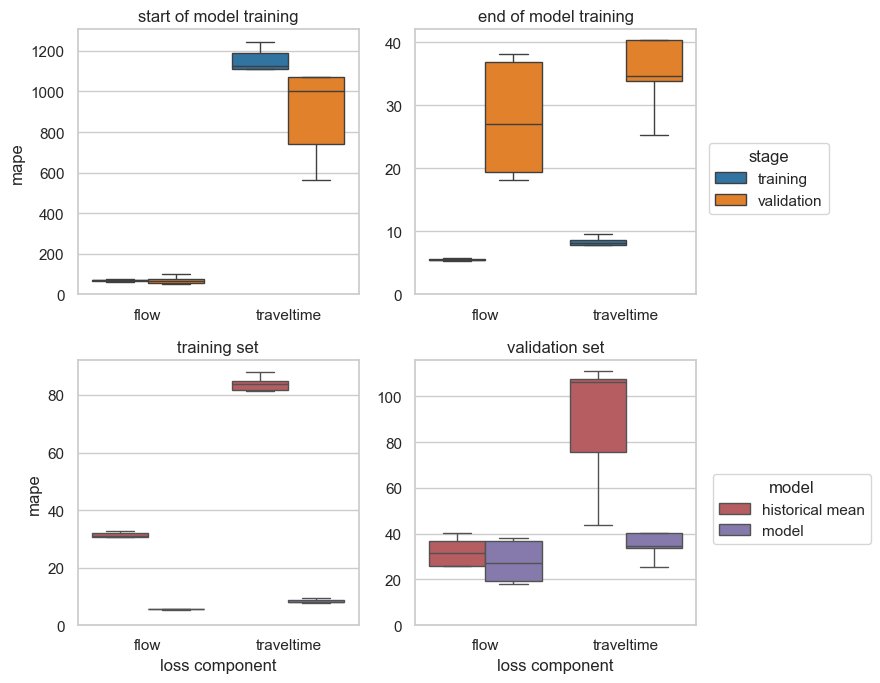

In [73]:
fig, axs = plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='mape', showfliers=False, sharey=False)
for ax in axs.reshape(-1):
    ax.set_ylim(bottom = 0)

plt.savefig('output/figures/experiments/siouxfalls-kfold-mape-tvgodlulpe', dpi = 300)

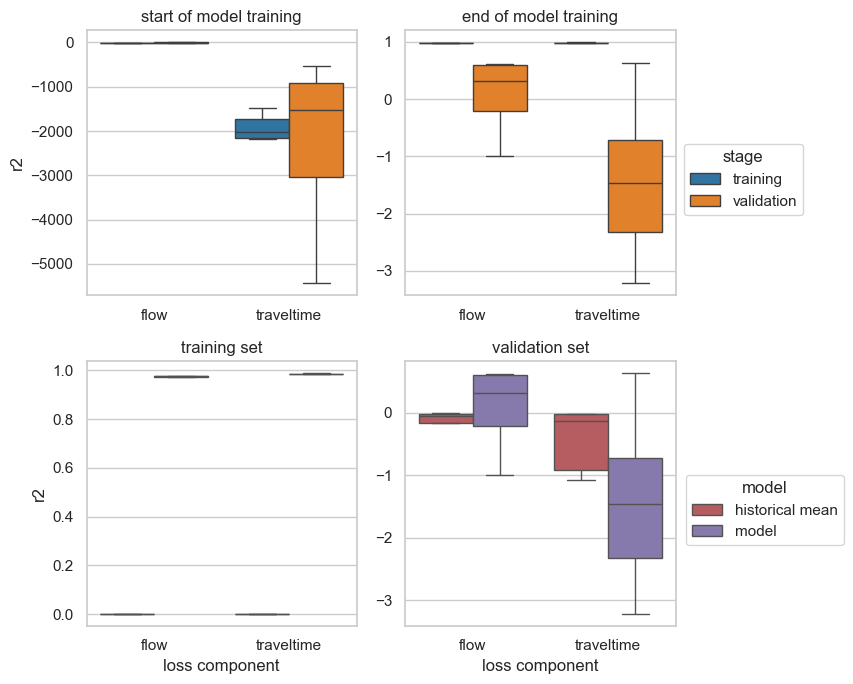

In [74]:
plot_metrics_kfold(df=metrics_kfold['tvgodlulpe'][metrics_kfold['tvgodlulpe'].component.isin(['flow', 'traveltime'])],
                   metric_name='r2', showfliers=False, sharey=False)
plt.show()

/Users/pablo/github/nesuelogit/src/nesuelogit/visualizations.py:200: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(data=df, x=x_label, y='value', hue='parameter', ax=axs, **kwargs)


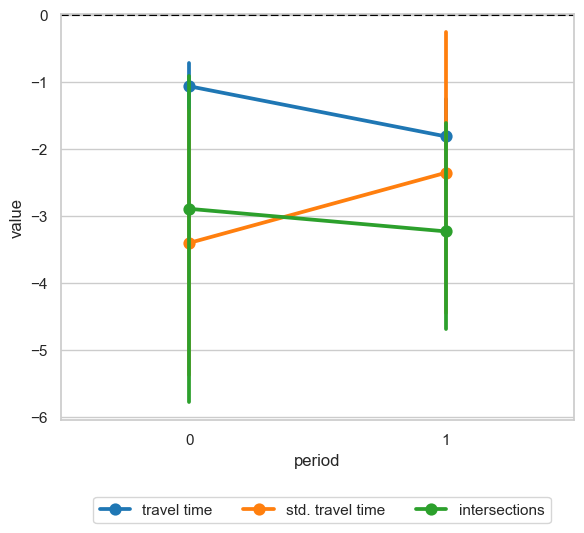

In [75]:
parameters_kfold['tvgodlulpe']['hour'] = parameters_kfold['tvgodlulpe'].period.replace({v: k for k, v in models_kfold['tvgodlulpe'].period_dict.items()}). \
    replace(dict(zip(period_keys.period_id, period_keys.hour)))

parameters_kfold['tvgodlulpe']['parameter'] = parameters_kfold['tvgodlulpe']['parameter'].\
    replace({'tt': 'travel time', 'tt_sd': 'std. travel time', 'vot': 'reliability ratio', 's': 'intersections'})

parameters_kfold['tvgodlulpe'] = parameters_kfold['tvgodlulpe'][parameters_kfold['tvgodlulpe'].parameter != 'reliability ratio']

plot_parameters_kfold(df=parameters_kfold['tvgodlulpe'], join=True, n_cols_legend = 3, figsize = (6,5.5))

plt.axhline(0, linestyle ='dashed', color = 'black')

plt.savefig('output/figures/experiments/siouxfalls-kfold-utility-periods-tvlulpe.png', dpi=300)

plt.show()

## Write with estimation results

In [76]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 231222195130_train_results_SiouxFalls.csv was written
File 231222195130_validation_results_SiouxFalls.csv was written


## Summary of models parameters

In [77]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model_key, model in models.items():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model_key)

    results = pd.concat([results, model_results])

In [78]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

model,tvodlulpe,tvgodlulpe
parameter,,
tt,-0.8310,-1.6443
tt_sd,-8.3115,-3.7838
s,-5.3168,-3.2715
rr,10.0023,2.3011
fixed_effect_mean,-0.9880,-0.1996
fixed_effect_std,4.0805,4.8025
od_mean,630.7292,615.6614
od_std,693.4413,1507.9302
alpha_mean,0.5899,NaN


## Summary of models goodness of fit

In [79]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for model_key, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model_key])[1].assign(model=model_key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [80]:
results_losses[['model'] + loss_columns].round(1)

,model,loss_flow,loss_traveltime,loss_equilibrium,loss_total
60,tvodlulpe,-96.3,-98.8,-99.7,-99.4
60,tvgodlulpe,-99.6,-100.0,-99.9,-99.8


## Plot of convergence toward true rr across models

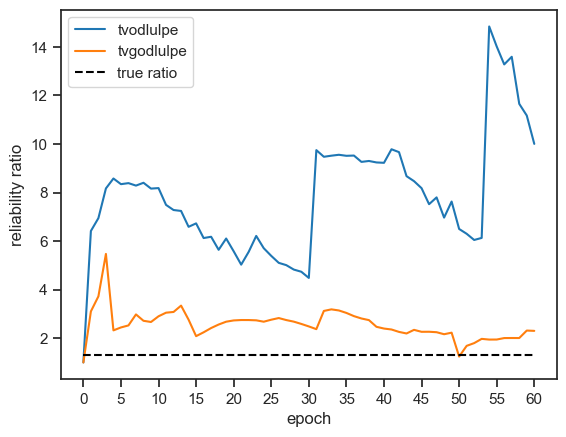

In [81]:
train_estimates = {}
train_losses = {}

for model_key, model in models.items():
    train_estimates[model_key], train_losses[model_key] = model.split_results(results=train_results_dfs[model_key])
    train_estimates[model_key]['model'] = model_key

train_estimates_df = pd.concat(train_estimates.values())
train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']
estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
#estimates = estimates[estimates.epoch != 0]

fig, ax = plt.subplots(nrows=1, ncols=1)
g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')
utility_true_values = models['tvodlulpe'].utility.true_values
ax.hlines(y=compute_rr(utility_true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'true ratio', color = 'black')
ax.set_ylabel('reliability ratio')
ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, 5))
plt.legend(loc = 'upper left')
plt.show()

## Plot of total trips by hour for all models

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_66193/2617092511.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0,1])


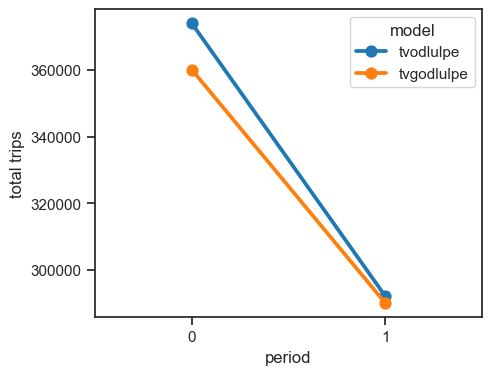

In [82]:
total_trips = compute_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys)

fig, ax = plt.subplots(figsize=(5, 4))

total_trips_by_hour_models = compute_total_trips_models(models = models, period_feature = period_feature,
                                                        period_keys = period_keys)

g = sns.pointplot(data= total_trips_by_hour_models, x=period_feature, y='total_trips', ax=ax, hue='model')

plt.ylabel('total trips', fontsize=12)

ax.set_xticklabels([0,1])
ax.set_xlabel('period')
ax.legend()

plt.legend(loc='upper right', title = 'model')

plt.show()

In [83]:
print(total_trips)

  hour   total_trips       model  order
0  1-2  373881.28125   tvodlulpe      1
0  1-2  360021.25000  tvgodlulpe      1
1  2-3  292169.09375   tvodlulpe      2
1  2-3  290117.12500  tvgodlulpe      2


In [84]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

,total_trips
model,
tvgodlulpe,325069.1875
tvodlulpe,333025.1875


In [85]:
total_trips.groupby('model')[['total_trips']].sum().round(1)

,total_trips
model,
tvgodlulpe,650138.375
tvodlulpe,666050.375


## Global runtime

In [86]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 14365.9 [s]
